In [1]:
# Cell 1: Import all required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Basic libraries imported")

# Machine Learning (we'll import more as needed)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("✓ Machine Learning libraries imported")

# For progress tracking
from tqdm import tqdm

print("✓ All libraries imported successfully!")
print("\nReady to download stock data...")

✓ Basic libraries imported
✓ Machine Learning libraries imported
✓ All libraries imported successfully!

Ready to download stock data...


In [2]:
# Cell 2: Download data for multiple stocks with longer time period
# Let's start with 5 major stocks from different sectors
stocks = {
    'AAPL': 'Technology',
    'MSFT': 'Technology',
    'JPM': 'Financial',
    'JNJ': 'Healthcare',
    'XOM': 'Energy'
}

# 15 years of data for better learning
start_date = '2008-01-01'
end_date = '2024-01-01'

print(f"Downloading {len(stocks)} stocks from {start_date} to {end_date}")
print("Stocks:", list(stocks.keys()))
print("=" * 60)

# Download data
all_stock_data = {}
failed_downloads = []

for ticker, sector in stocks.items():
    try:
        print(f"Downloading {ticker} ({sector})...")
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        if not data.empty:
            all_stock_data[ticker] = data
            print(f"  ✓ Success: {len(data)} trading days")
        else:
            failed_downloads.append(ticker)
            print(f"  ✗ Failed: No data returned")
            
    except Exception as e:
        failed_downloads.append(ticker)
        print(f"  ✗ Error: {str(e)[:50]}")

print("\n" + "=" * 60)
print(f"DOWNLOAD SUMMARY:")
print(f"Successfully downloaded: {len(all_stock_data)} stocks")
print(f"Failed downloads: {failed_downloads}")

# Show detailed info for first successful stock
if all_stock_data:
    first_ticker = list(all_stock_data.keys())[0]
    first_data = all_stock_data[first_ticker]
    
    print(f"\nDETAILED INFO FOR {first_ticker}:")
    print(f"Shape: {first_data.shape}")
    print(f"Date range: {first_data.index.min()} to {first_data.index.max()}")
    print(f"Total trading days: {len(first_data)}")
    print(f"Years of data: {(first_data.index.max() - first_data.index.min()).days / 365:.1f}")
    
    print(f"\nColumns (MultiIndex):")
    for col in first_data.columns:
        print(f"  {col}")
    
    print(f"\nFirst 3 rows:")
    print(first_data.head(3))
    
    print(f"\nLast 3 rows:")
    print(first_data.tail(3))

Stocks: ['AAPL', 'MSFT', 'JPM', 'JNJ', 'XOM']
  ✓ Success: 4027 trading days
  ✓ Success: 4027 trading days
  ✓ Success: 4027 trading days
  ✓ Success: 4027 trading days
  ✓ Success: 4027 trading days

DOWNLOAD SUMMARY:
Successfully downloaded: 5 stocks
Failed downloads: []

DETAILED INFO FOR AAPL:
Shape: (4027, 5)
Date range: 2008-01-02 00:00:00 to 2023-12-29 00:00:00
Total trading days: 4027
Years of data: 16.0

Columns (MultiIndex):
  ('Close', 'AAPL')
  ('High', 'AAPL')
  ('Low', 'AAPL')
  ('Open', 'AAPL')
  ('Volume', 'AAPL')

First 3 rows:
Price          Close      High       Low      Open      Volume
Ticker          AAPL      AAPL      AAPL      AAPL        AAPL
Date                                                          
2008-01-02  5.837991  6.000391  5.769377  5.970728  1079178800
2008-01-03  5.840689  5.914398  5.773572  5.855072   842066400
2008-01-04  5.394840  5.782861  5.360084  5.736419  1455832000

Last 3 rows:
Price            Close        High         Low        Op

In [3]:
# Cell 3: Process AAPL data and create comprehensive features
print("Processing AAPL data and creating features...")
print("=" * 60)

# Get AAPL data
aapl_data = all_stock_data['AAPL'].copy()

# Check the data structure - it has MultiIndex columns
print("Original data structure:")
print(f"Columns (MultiIndex): {aapl_data.columns}")
print(f"Column types: {type(aapl_data.columns)}")

# Let's flatten the column names for easier processing
aapl_data_flat = aapl_data.copy()
# The columns are tuples like ('Close', 'AAPL'), ('High', 'AAPL'), etc.
aapl_data_flat.columns = [f"{col[1]}_{col[0]}" for col in aapl_data_flat.columns]

print(f"\nFlattened column names:")
for col in aapl_data_flat.columns:
    print(f"  {col}")

# Create a clean dataframe
df = aapl_data_flat.copy()
print(f"\nDataFrame shape: {df.shape}")
print(f"\nFirst 3 rows:")
print(df.head(3))

# Create target variable: Predict 5 days ahead
prediction_horizon = 5
print(f"\nCreating target: Predicting price {prediction_horizon} days ahead...")
df['Target'] = df['AAPL_Close'].shift(-prediction_horizon)

# Create comprehensive features
print("\nCreating technical indicators and features...")

# 1. Basic price features
df['Return'] = df['AAPL_Close'].pct_change()
df['Log_Return'] = np.log(df['AAPL_Close'] / df['AAPL_Close'].shift(1))

# 2. Moving Averages
windows = [5, 10, 20, 50, 100, 200]
for window in windows:
    df[f'MA_{window}'] = df['AAPL_Close'].rolling(window=window).mean()
    df[f'Std_{window}'] = df['AAPL_Close'].rolling(window=window).std()

# 3. Moving Average Crossovers
df['MA_5_20_Crossover'] = df['MA_5'] - df['MA_20']
df['MA_20_50_Crossover'] = df['MA_20'] - df['MA_50']
df['MA_50_200_Crossover'] = df['MA_50'] - df['MA_200']

# 4. Price relative to Moving Averages
for window in [20, 50, 200]:
    df[f'Price_MA{window}_Ratio'] = df['AAPL_Close'] / df[f'MA_{window}']

# 5. Volatility measures
df['Volatility_20'] = df['Return'].rolling(window=20).std()
df['Volatility_50'] = df['Return'].rolling(window=50).std()

# 6. High-Low features
df['High_Low_Range'] = (df['AAPL_High'] - df['AAPL_Low']) / df['AAPL_Close']
df['Close_Open_Gap'] = (df['AAPL_Close'] - df['AAPL_Open']) / df['AAPL_Open']

# 7. Volume indicators
df['Volume_MA_20'] = df['AAPL_Volume'].rolling(window=20).mean()
df['Volume_Ratio'] = df['AAPL_Volume'] / df['Volume_MA_20']
df['Volume_Price_Trend'] = df['Volume_Ratio'] * df['Return']

# 8. Lag features
for lag in [1, 2, 3, 5, 10]:
    df[f'Price_Lag_{lag}'] = df['AAPL_Close'].shift(lag)
    df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)

# 9. Rolling statistics
df['Rolling_Max_20'] = df['AAPL_Close'].rolling(window=20).max()
df['Rolling_Min_20'] = df['AAPL_Close'].rolling(window=20).min()
df['Price_Position'] = (df['AAPL_Close'] - df['Rolling_Min_20']) / (df['Rolling_Max_20'] - df['Rolling_Min_20'])

# 10. Momentum indicators
df['Momentum_5'] = df['AAPL_Close'] - df['AAPL_Close'].shift(5)
df['Momentum_20'] = df['AAPL_Close'] - df['AAPL_Close'].shift(20)

# 11. Rate of Change
df['ROC_5'] = (df['AAPL_Close'] - df['AAPL_Close'].shift(5)) / df['AAPL_Close'].shift(5)
df['ROC_20'] = (df['AAPL_Close'] - df['AAPL_Close'].shift(20)) / df['AAPL_Close'].shift(20)

# Drop rows with NaN values (from rolling calculations and target)
initial_rows = len(df)
df_clean = df.dropna().copy()
final_rows = len(df_clean)

print(f"\nData cleaning:")
print(f"  Initial rows: {initial_rows}")
print(f"  After cleaning: {final_rows}")
print(f"  Rows removed: {initial_rows - final_rows}")

print(f"\nFinal feature count: {len(df_clean.columns)}")
print(f"Features created: {len(df_clean.columns) - 6}")  # Subtract original 5 columns + target

# Show feature categories
feature_categories = {
    'Price Features': ['Return', 'Log_Return'],
    'Moving Averages': [col for col in df_clean.columns if 'MA_' in col and 'Crossover' not in col and 'Ratio' not in col],
    'Crossovers': [col for col in df_clean.columns if 'Crossover' in col],
    'Ratios': [col for col in df_clean.columns if 'Ratio' in col],
    'Volatility': [col for col in df_clean.columns if 'Volatility' in col or 'Std_' in col],
    'Volume': [col for col in df_clean.columns if 'Volume' in col],
    'Lag Features': [col for col in df_clean.columns if 'Lag_' in col],
    'Momentum': [col for col in df_clean.columns if 'Momentum' in col or 'ROC_' in col]
}

print(f"\nFeature Categories:")
for category, features in feature_categories.items():
    if features:  # Only show non-empty categories
        print(f"  {category}: {len(features)} features")

Processing AAPL data and creating features...
Original data structure:
Columns (MultiIndex): MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Column types: <class 'pandas.core.indexes.multi.MultiIndex'>

Flattened column names:
  AAPL_Close
  AAPL_High
  AAPL_Low
  AAPL_Open
  AAPL_Volume

DataFrame shape: (4027, 5)

First 3 rows:
            AAPL_Close  AAPL_High  AAPL_Low  AAPL_Open  AAPL_Volume
Date                                                               
2008-01-02    5.837991   6.000391  5.769377   5.970728   1079178800
2008-01-03    5.840689   5.914398  5.773572   5.855072    842066400
2008-01-04    5.394840   5.782861  5.360084   5.736419   1455832000

Creating target: Predicting price 5 days ahead...

Creating technical indicators and features...

Data cleaning:
  Initial rows: 4027
  After cleaning: 3823
  Rows removed: 204

In [4]:
# Cell 4: Prepare features and target for modeling
print("Preparing data for modeling...")
print("=" * 60)

# Define features to exclude (we don't want to use future information)
exclude_features = [
    'Target',  # Our target variable
    'AAPL_Close', 'AAPL_High', 'AAPL_Low', 'AAPL_Open', 'AAPL_Volume',  # Raw price data
    'Return', 'Log_Return'  # Current returns (calculated from current close)
]

# Only exclude features that exist in our dataframe
exclude_features = [col for col in exclude_features if col in df_clean.columns]

print(f"Excluding {len(exclude_features)} features:")
for feature in exclude_features:
    print(f"  - {feature}")

# Get all feature columns
feature_cols = [col for col in df_clean.columns if col not in exclude_features]

print(f"\nUsing {len(feature_cols)} features for prediction:")
print(f"First 10 features:")
for i, feature in enumerate(feature_cols[:10]):
    print(f"  {i+1}. {feature}")

# Create X (features) and y (target)
X = df_clean[feature_cols]
y = df_clean['Target']

print(f"\nDataset shapes:")
print(f"X (features): {X.shape}")
print(f"y (target): {y.shape}")

# Show target statistics
print(f"\nTarget (AAPL_Close price {prediction_horizon} days ahead) statistics:")
print(f"Mean: ${y.mean():.2f}")
print(f"Std: ${y.std():.2f}")
print(f"Min: ${y.min():.2f}")
print(f"Max: ${y.max():.2f}")
print(f"Range: ${y.max() - y.min():.2f}")

# Check for any remaining NaN values
print(f"\nNaN check:")
print(f"X has NaN: {X.isna().sum().sum()} NaN values")
print(f"y has NaN: {y.isna().sum()} NaN values")

# Show correlation of top features with target
print(f"\nTop 10 features with highest correlation to target:")
correlations = X.corrwith(y).abs().sort_values(ascending=False)
for i, (feature, corr) in enumerate(correlations.head(10).items()):
    print(f"  {i+1}. {feature}: {corr:.4f}")

# Split data into training and testing sets (time-based split)
print(f"\nSplitting data (time-based, not random)...")
split_ratio = 0.8  # 80% training, 20% testing
split_index = int(len(X) * split_ratio)

print(f"Total samples: {len(X)}")
print(f"Split index: {split_index} ({(split_index/len(X))*100:.1f}% for training)")

# Split the data
X_train_raw = X.iloc[:split_index]
X_test_raw = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"\nTraining set:")
print(f"  Samples: {len(X_train_raw)}")
print(f"  Date range: {X_train_raw.index.min()} to {X_train_raw.index.max()}")
print(f"  Years: {(X_train_raw.index.max() - X_train_raw.index.min()).days / 365:.1f}")

print(f"\nTesting set:")
print(f"  Samples: {len(X_test_raw)}")
print(f"  Date range: {X_test_raw.index.min()} to {X_test_raw.index.max()}")
print(f"  Years: {(X_test_raw.index.max() - X_test_raw.index.min()).days / 365:.1f}")

# Scale features
print(f"\nScaling features using StandardScaler...")
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrames with column names
X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_raw.index)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test_raw.index)

print("✓ Feature scaling completed")

# Verify scaling
print(f"\nScaled feature verification (training set):")
print(f"  Mean of scaled features: {X_train.mean().mean():.6f} (should be ~0)")
print(f"  Std of scaled features: {X_train.std().mean():.6f} (should be ~1)")

print(f"\n✓ Data preparation completed successfully!")
print(f"  Ready for modeling with {X_train.shape[1]} features")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")

Preparing data for modeling...
Excluding 8 features:
  - Target
  - AAPL_Close
  - AAPL_High
  - AAPL_Low
  - AAPL_Open
  - AAPL_Volume
  - Return
  - Log_Return

Using 42 features for prediction:
First 10 features:
  1. MA_5
  2. Std_5
  3. MA_10
  4. Std_10
  5. MA_20
  6. Std_20
  7. MA_50
  8. Std_50
  9. MA_100
  10. Std_100

Dataset shapes:
X (features): (3823, 42)
y (target): (3823,)

Target (AAPL_Close price 5 days ahead) statistics:
Mean: $53.14
Std: $54.96
Min: $2.34
Max: $196.07
Range: $193.73

NaN check:
X has NaN: 0 NaN values
y has NaN: 0 NaN values

Top 10 features with highest correlation to target:
  1. Price_Lag_1: 0.9983
  2. MA_5: 0.9983
  3. Price_Lag_2: 0.9980
  4. MA_10: 0.9978
  5. Price_Lag_3: 0.9977
  6. Price_Lag_5: 0.9972
  7. MA_20: 0.9969
  8. Rolling_Max_20: 0.9966
  9. Rolling_Min_20: 0.9965
  10. Price_Lag_10: 0.9958

Splitting data (time-based, not random)...
Total samples: 3823
Split index: 3058 (80.0% for training)

Training set:
  Samples: 3058
  Da

Defining evaluation metrics and training Linear Regression...
✓ Evaluation functions defined

TRAINING LINEAR REGRESSION MODEL
Training Linear Regression...
✓ Model trained successfully

TRAINING SET EVALUATION:

EVALUATION: Linear Regression (Training)
MSE:  2.5567
RMSE: $1.60
MAE:  $0.87
R²:   0.9955
MAPE: 3.52%
Directional Accuracy: 51.32%

INTERPRETATION:
• R² of 0.9955 means the model explains 99.5% of variance
• Average error is $0.87 per prediction
• Percentage error is 3.5% on average

TESTING SET EVALUATION:

EVALUATION: Linear Regression (Testing)
MSE:  39.4772
RMSE: $6.28
MAE:  $4.90
R²:   0.9029
MAPE: 3.27%
Directional Accuracy: 52.62%

INTERPRETATION:
• R² of 0.9029 means the model explains 90.3% of variance
• Average error is $4.90 per prediction
• Percentage error is 3.3% on average


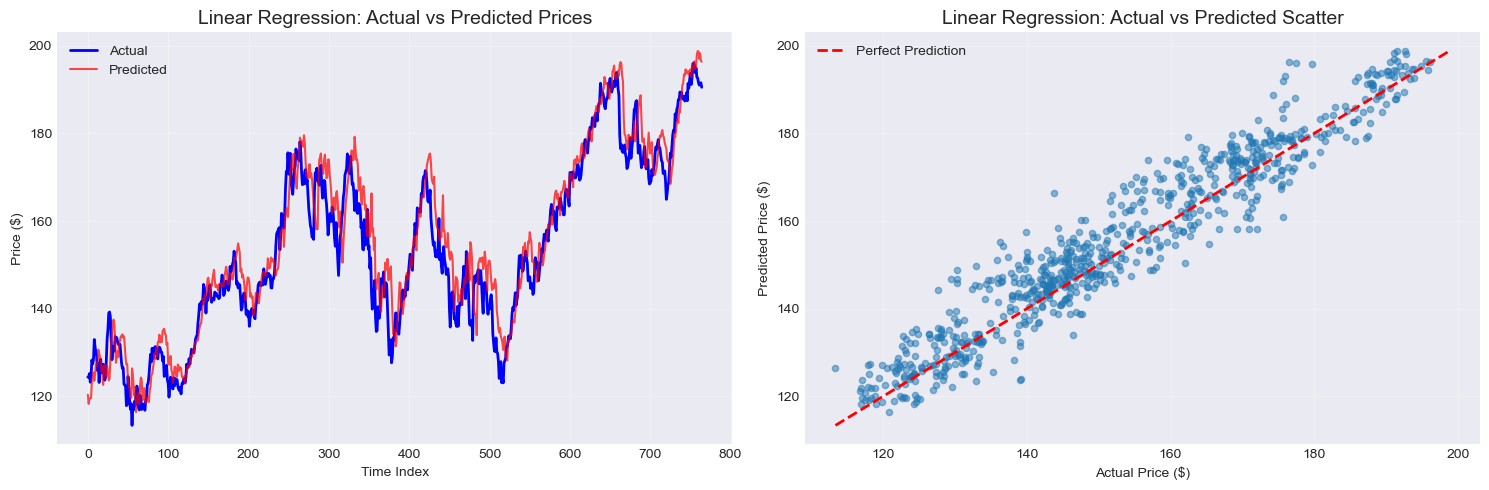

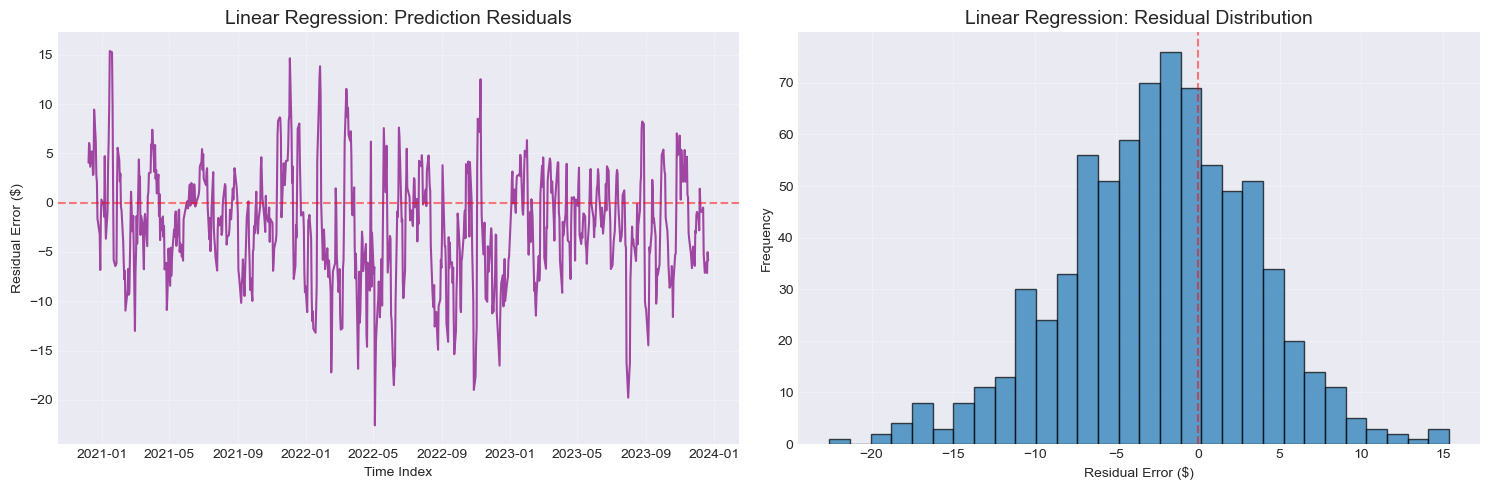


LINEAR REGRESSION COMPLETED
Next: Training more complex models for comparison...


In [5]:
# Cell 5: Define comprehensive evaluation function and train Linear Regression
print("Defining evaluation metrics and training Linear Regression...")
print("=" * 60)

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Comprehensive evaluation function with multiple metrics
    """
    # Calculate all metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error) with epsilon to avoid division by zero
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    
    # Directional Accuracy
    if len(y_true) > 1:
        direction_true = np.diff(y_true) > 0
        direction_pred = np.diff(y_pred) > 0
        min_len = min(len(direction_true), len(direction_pred))
        if min_len > 0:
            directional_accuracy = np.mean(direction_true[:min_len] == direction_pred[:min_len])
        else:
            directional_accuracy = np.nan
    else:
        directional_accuracy = np.nan
    
    # Create results dictionary
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy
    }
    
    # Print formatted results
    print(f"\n{'='*50}")
    print(f"EVALUATION: {model_name}")
    print(f"{'='*50}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE:  ${mae:.2f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    if not np.isnan(directional_accuracy):
        print(f"Directional Accuracy: {directional_accuracy:.2%}")
    
    # Interpretation
    print(f"\nINTERPRETATION:")
    print(f"• R² of {r2:.4f} means the model explains {r2*100:.1f}% of variance")
    print(f"• Average error is ${mae:.2f} per prediction")
    print(f"• Percentage error is {mape:.1f}% on average")
    
    return results

def plot_predictions(y_true, y_pred, model_name, dates=None):
    """
    Visualize predictions vs actual values
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Time series comparison
    if dates is not None:
        axes[0].plot(dates, y_true, label='Actual', color='blue', linewidth=2)
        axes[0].plot(dates, y_pred, label='Predicted', color='red', linewidth=1.5, alpha=0.7)
    else:
        axes[0].plot(y_true.values, label='Actual', color='blue', linewidth=2)
        axes[0].plot(y_pred, label='Predicted', color='red', linewidth=1.5, alpha=0.7)
    
    axes[0].set_title(f'{model_name}: Actual vs Predicted Prices', fontsize=14)
    axes[0].set_xlabel('Time Index')
    axes[0].set_ylabel('Price ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot with perfect prediction line
    axes[1].scatter(y_true, y_pred, alpha=0.5, s=20)
    # Perfect prediction line (y = x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 
                 'r--', linewidth=2, label='Perfect Prediction')
    axes[1].set_title(f'{model_name}: Actual vs Predicted Scatter', fontsize=14)
    axes[1].set_xlabel('Actual Price ($)')
    axes[1].set_ylabel('Predicted Price ($)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    residuals = y_true - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(residuals, color='purple', alpha=0.7)
    axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0].set_title(f'{model_name}: Prediction Residuals', fontsize=14)
    axes[0].set_xlabel('Time Index')
    axes[0].set_ylabel('Residual Error ($)')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    axes[1].set_title(f'{model_name}: Residual Distribution', fontsize=14)
    axes[1].set_xlabel('Residual Error ($)')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Evaluation functions defined")

# Now train Linear Regression model
print("\n" + "="*60)
print("TRAINING LINEAR REGRESSION MODEL")
print("="*60)

from sklearn.linear_model import LinearRegression

# Create and train model
lr_model = LinearRegression()
print("Training Linear Regression...")
lr_model.fit(X_train, y_train)
print("✓ Model trained successfully")

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate
print("\nTRAINING SET EVALUATION:")
train_results_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression (Training)")

print("\nTESTING SET EVALUATION:")
test_results_lr = evaluate_model(y_test, y_test_pred_lr, "Linear Regression (Testing)")

# Plot predictions
plot_predictions(y_test, y_test_pred_lr, "Linear Regression")

# Store results
lr_results = {
    'model': lr_model,
    'train_metrics': train_results_lr,
    'test_metrics': test_results_lr,
    'predictions': y_test_pred_lr
}

print("\n" + "="*60)
print("LINEAR REGRESSION COMPLETED")
print("="*60)
print("Next: Training more complex models for comparison...")

Training multiple models for comparison...

TRAINING: Decision Tree
Training Decision Tree...
✓ Decision Tree trained successfully

TESTING SET EVALUATION:

EVALUATION: Decision Tree (Testing)
MSE:  1731.5867
RMSE: $41.61
MAE:  $36.28
R²:   -3.2603
MAPE: 22.40%
Directional Accuracy: 47.64%

INTERPRETATION:
• R² of -3.2603 means the model explains -326.0% of variance
• Average error is $36.28 per prediction
• Percentage error is 22.4% on average


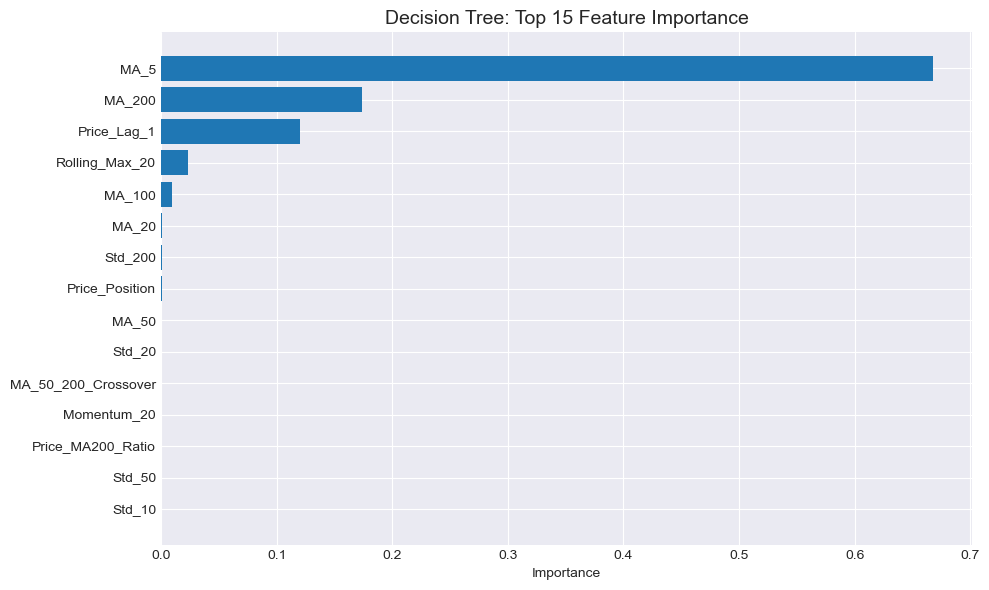


Top 5 most important features for Decision Tree:
  1. MA_5: 0.6682
  11. MA_200: 0.1738
  26. Price_Lag_1: 0.1205
  36. Rolling_Max_20: 0.0232
  9. MA_100: 0.0095

TRAINING: Random Forest
Training Random Forest...
✓ Random Forest trained successfully

TESTING SET EVALUATION:

EVALUATION: Random Forest (Testing)
MSE:  2083.4014
RMSE: $45.64
MAE:  $41.32
R²:   -4.1259
MAPE: 25.83%
Directional Accuracy: 51.18%

INTERPRETATION:
• R² of -4.1259 means the model explains -412.6% of variance
• Average error is $41.32 per prediction
• Percentage error is 25.8% on average


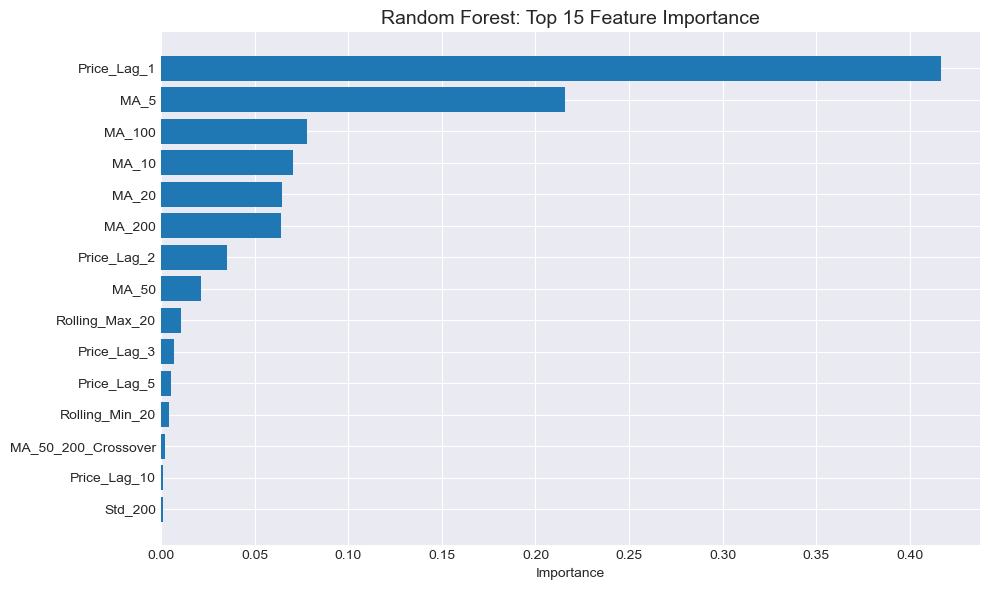


Top 5 most important features for Random Forest:
  26. Price_Lag_1: 0.4166
  1. MA_5: 0.2158
  9. MA_100: 0.0778
  3. MA_10: 0.0704
  5. MA_20: 0.0645

TRAINING: Gradient Boosting
Training Gradient Boosting...
✓ Gradient Boosting trained successfully

TESTING SET EVALUATION:

EVALUATION: Gradient Boosting (Testing)
MSE:  2028.2640
RMSE: $45.04
MAE:  $40.52
R²:   -3.9902
MAPE: 25.27%
Directional Accuracy: 53.14%

INTERPRETATION:
• R² of -3.9902 means the model explains -399.0% of variance
• Average error is $40.52 per prediction
• Percentage error is 25.3% on average


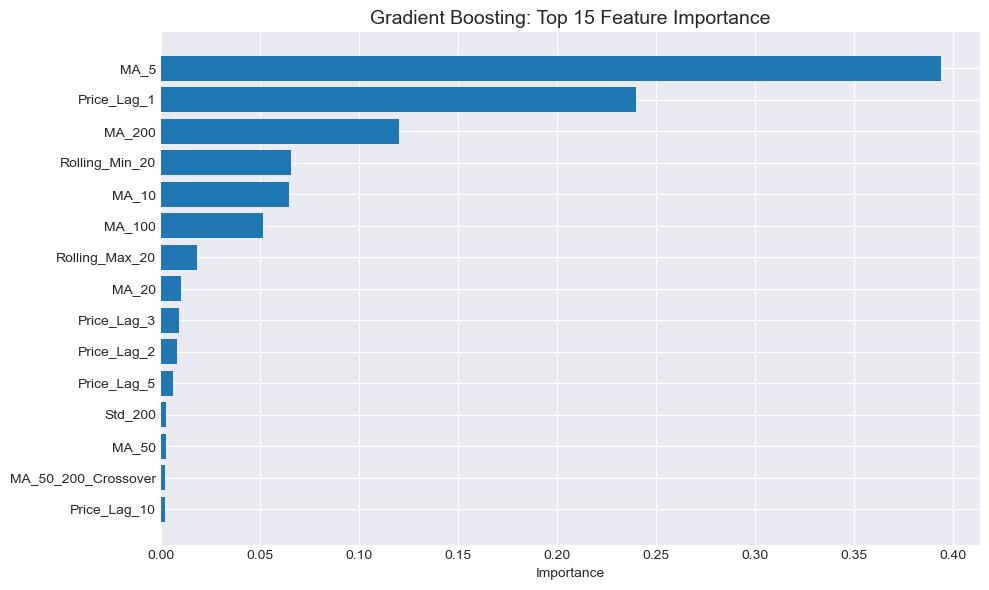


Top 5 most important features for Gradient Boosting:
  1. MA_5: 0.3941
  26. Price_Lag_1: 0.2398
  11. MA_200: 0.1204
  37. Rolling_Min_20: 0.0656
  3. MA_10: 0.0648

TRAINING: XGBoost
Training XGBoost...
✓ XGBoost trained successfully

TESTING SET EVALUATION:

EVALUATION: XGBoost (Testing)
MSE:  2742.5971
RMSE: $52.37
MAE:  $48.53
R²:   -5.7477
MAPE: 30.65%
Directional Accuracy: 51.96%

INTERPRETATION:
• R² of -5.7477 means the model explains -574.8% of variance
• Average error is $48.53 per prediction
• Percentage error is 30.6% on average


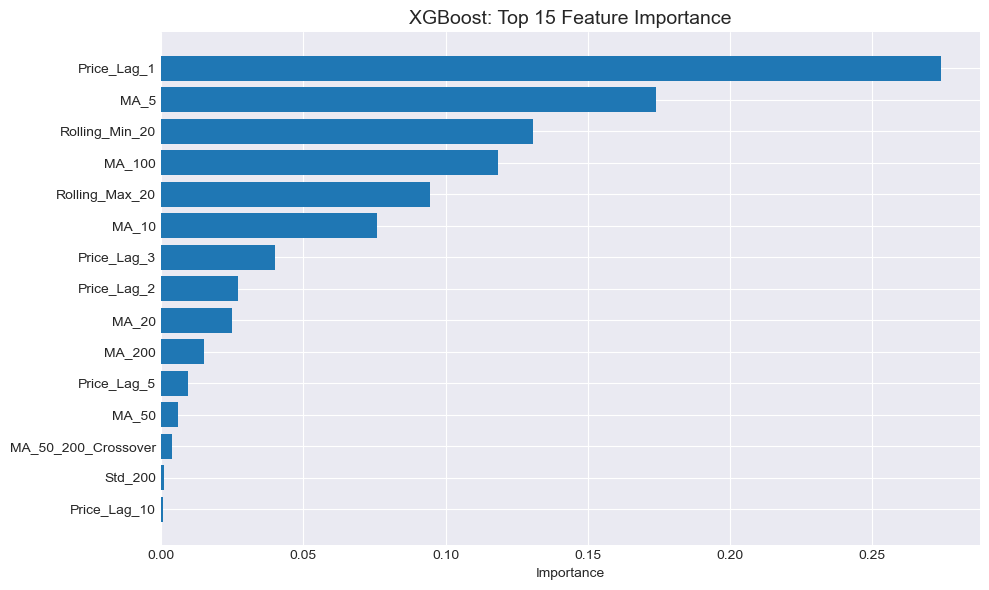


Top 5 most important features for XGBoost:
  26. Price_Lag_1: 0.2741
  1. MA_5: 0.1740
  37. Rolling_Min_20: 0.1306
  9. MA_100: 0.1186
  36. Rolling_Max_20: 0.0944

MODEL TRAINING COMPLETED
Total models trained: 5


In [6]:
# Cell 6: Train multiple models for comprehensive comparison
print("Training multiple models for comparison...")
print("=" * 60)

# Import additional models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# We'll train these models:
models_to_train = {
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, verbosity=0)
}

# Store all results
all_results = {
    'Linear Regression': lr_results
}

# Train each model
for model_name, model in models_to_train.items():
    print(f"\n{'='*50}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*50}")
    
    try:
        # Train model
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)
        print(f"✓ {model_name} trained successfully")
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Evaluate
        print(f"\nTESTING SET EVALUATION:")
        test_results = evaluate_model(y_test, y_test_pred, f"{model_name} (Testing)")
        
        # Store results
        all_results[model_name] = {
            'model': model,
            'test_metrics': test_results,
            'predictions': y_test_pred
        }
        
        # Plot feature importance for tree-based models
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            # Plot top 15 features
            plt.figure(figsize=(10, 6))
            top_features = feature_importance.head(15)
            plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
            plt.title(f'{model_name}: Top 15 Feature Importance', fontsize=14)
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
            
            print(f"\nTop 5 most important features for {model_name}:")
            for i, row in feature_importance.head(5).iterrows():
                print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
        
    except Exception as e:
        print(f"✗ Error training {model_name}: {str(e)[:100]}")

print(f"\n{'='*60}")
print(f"MODEL TRAINING COMPLETED")
print(f"Total models trained: {len(all_results)}")
print(f"{'='*60}")

Training regularized models and creating comparison...

TRAINING: Ridge Regression
Training Ridge Regression...
✓ Ridge Regression trained successfully

TESTING SET EVALUATION:

EVALUATION: Ridge Regression (Testing)
MSE:  40.1331
RMSE: $6.34
MAE:  $4.96
R²:   0.9013
MAPE: 3.31%
Directional Accuracy: 52.62%

INTERPRETATION:
• R² of 0.9013 means the model explains 90.1% of variance
• Average error is $4.96 per prediction
• Percentage error is 3.3% on average

TRAINING: Lasso Regression
Training Lasso Regression...
✓ Lasso Regression trained successfully

TESTING SET EVALUATION:

EVALUATION: Lasso Regression (Testing)
MSE:  35.8427
RMSE: $5.99
MAE:  $4.65
R²:   0.9118
MAPE: 3.10%
Directional Accuracy: 53.66%

INTERPRETATION:
• R² of 0.9118 means the model explains 91.2% of variance
• Average error is $4.65 per prediction
• Percentage error is 3.1% on average

TRAINING: ElasticNet
Training ElasticNet...
✓ ElasticNet trained successfully

TESTING SET EVALUATION:

EVALUATION: ElasticNet (Te

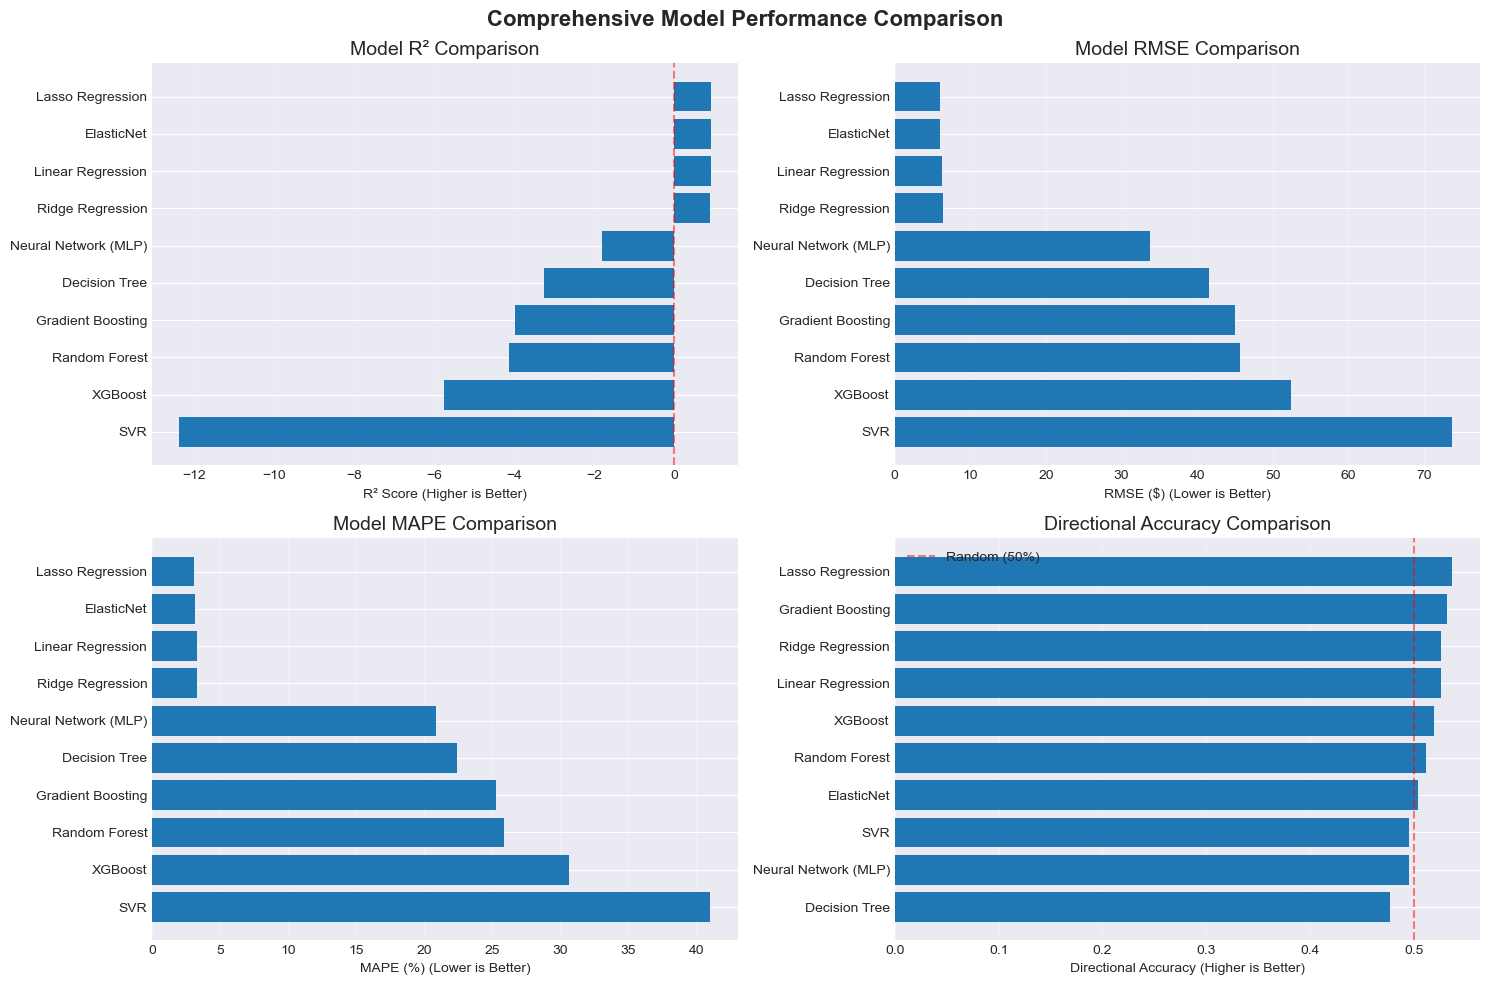


✓ All models trained and compared successfully!


In [7]:
# Cell 7: Train regularized models and create comprehensive comparison
print("Training regularized models and creating comparison...")
print("=" * 60)

# Import regularized models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Regularized linear models
regularized_models = {
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1),
    'Neural Network (MLP)': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        random_state=42,
        early_stopping=True
    )
}

# Train regularized models
for model_name, model in regularized_models.items():
    print(f"\n{'='*50}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*50}")
    
    try:
        # Train model
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)
        print(f"✓ {model_name} trained successfully")
        
        # Make predictions
        y_test_pred = model.predict(X_test)
        
        # Evaluate
        print(f"\nTESTING SET EVALUATION:")
        test_results = evaluate_model(y_test, y_test_pred, f"{model_name} (Testing)")
        
        # Store results
        all_results[model_name] = {
            'model': model,
            'test_metrics': test_results,
            'predictions': y_test_pred
        }
        
    except Exception as e:
        print(f"✗ Error training {model_name}: {str(e)[:100]}")

print(f"\n{'='*60}")
print("ALL MODELS TRAINED")
print(f"Total models in comparison: {len(all_results)}")
print(f"{'='*60}")

# Create comprehensive comparison table
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

comparison_data = []
for model_name, results in all_results.items():
    metrics = results['test_metrics']
    comparison_data.append({
        'Model': model_name,
        'RMSE': f"${metrics['RMSE']:.2f}",
        'MAE': f"${metrics['MAE']:.2f}",
        'R²': f"{metrics['R2']:.4f}",
        'MAPE': f"{metrics['MAPE']:.2f}%",
        'Directional_Acc': f"{metrics['Directional_Accuracy']:.2%}" if not np.isnan(metrics['Directional_Accuracy']) else "N/A"
    })

# Create DataFrame and sort by R² (descending)
comparison_df = pd.DataFrame(comparison_data)

# Extract numeric R² for sorting
def extract_r2(r2_str):
    try:
        return float(r2_str)
    except:
        return -float('inf')

comparison_df['R2_numeric'] = comparison_df['R²'].apply(extract_r2)
comparison_df = comparison_df.sort_values('R2_numeric', ascending=False)
comparison_df = comparison_df.drop('R2_numeric', axis=1)

print("\nModels sorted by R² Score (Higher is Better):")
print("-" * 85)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_r2 = comparison_df.iloc[0]['R²']
best_rmse = comparison_df.iloc[0]['RMSE']

print(f"\n{'='*80}")
print(f"🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   R² Score: {best_r2}")
print(f"   RMSE: {best_rmse}")
print(f"{'='*80}")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. R² Comparison (Bar Chart)
r2_values = [extract_r2(row['R²']) for _, row in comparison_df.iterrows()]
model_names = comparison_df['Model'].tolist()

# Sort by R² for bar chart
sorted_idx = np.argsort(r2_values)[::-1]
sorted_r2 = [r2_values[i] for i in sorted_idx]
sorted_names = [model_names[i] for i in sorted_idx]

axes[0, 0].barh(range(len(sorted_names)), sorted_r2)
axes[0, 0].set_yticks(range(len(sorted_names)))
axes[0, 0].set_yticklabels(sorted_names)
axes[0, 0].set_xlabel('R² Score (Higher is Better)')
axes[0, 0].set_title('Model R² Comparison', fontsize=14)
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. RMSE Comparison
def extract_rmse(rmse_str):
    return float(rmse_str.replace('$', ''))

rmse_values = [extract_rmse(row['RMSE']) for _, row in comparison_df.iterrows()]
sorted_idx_rmse = np.argsort(rmse_values)
sorted_rmse = [rmse_values[i] for i in sorted_idx_rmse]
sorted_names_rmse = [model_names[i] for i in sorted_idx_rmse]

axes[0, 1].barh(range(len(sorted_names_rmse)), sorted_rmse)
axes[0, 1].set_yticks(range(len(sorted_names_rmse)))
axes[0, 1].set_yticklabels(sorted_names_rmse)
axes[0, 1].set_xlabel('RMSE ($) (Lower is Better)')
axes[0, 1].set_title('Model RMSE Comparison', fontsize=14)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. MAPE Comparison
def extract_mape(mape_str):
    return float(mape_str.replace('%', ''))

mape_values = [extract_mape(row['MAPE']) for _, row in comparison_df.iterrows()]
sorted_idx_mape = np.argsort(mape_values)
sorted_mape = [mape_values[i] for i in sorted_idx_mape]
sorted_names_mape = [model_names[i] for i in sorted_idx_mape]

axes[1, 0].barh(range(len(sorted_names_mape)), sorted_mape)
axes[1, 0].set_yticks(range(len(sorted_names_mape)))
axes[1, 0].set_yticklabels(sorted_names_mape)
axes[1, 0].set_xlabel('MAPE (%) (Lower is Better)')
axes[1, 0].set_title('Model MAPE Comparison', fontsize=14)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Directional Accuracy Comparison
def extract_dir_acc(dir_acc_str):
    if dir_acc_str == 'N/A':
        return 0
    return float(dir_acc_str.replace('%', '')) / 100

# Filter models with directional accuracy
valid_models = []
valid_dir_acc = []
for _, row in comparison_df.iterrows():
    if row['Directional_Acc'] != 'N/A':
        valid_models.append(row['Model'])
        valid_dir_acc.append(extract_dir_acc(row['Directional_Acc']))

if valid_models:
    sorted_idx_dir = np.argsort(valid_dir_acc)[::-1]
    sorted_dir_acc = [valid_dir_acc[i] for i in sorted_idx_dir]
    sorted_names_dir = [valid_models[i] for i in sorted_idx_dir]
    
    axes[1, 1].barh(range(len(sorted_names_dir)), sorted_dir_acc)
    axes[1, 1].set_yticks(range(len(sorted_names_dir)))
    axes[1, 1].set_yticklabels(sorted_names_dir)
    axes[1, 1].set_xlabel('Directional Accuracy (Higher is Better)')
    axes[1, 1].set_title('Directional Accuracy Comparison', fontsize=14)
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
    axes[1, 1].legend()
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(True, alpha=0.3, axis='x')
else:
    axes[1, 1].axis('off')
    axes[1, 1].text(0.5, 0.5, 'No Directional Accuracy Data', 
                   ha='center', va='center', fontsize=12)

plt.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ All models trained and compared successfully!")

Deep analysis of best model and trying ensemble methods...
BEST MODEL: Lasso Regression
Test R²: 0.9118
Test RMSE: $5.99
Test MAE: $4.65

FEATURE IMPORTANCE ANALYSIS (Lasso Coefficients)

Top 15 Most Important Features (by coefficient magnitude):
------------------------------------------------------------
32. Price_Lag_5                    + 10.8924
 1. MA_5                           + 6.2091
 3. MA_10                          + 1.7270
 5. MA_20                          + 1.6845
11. MA_200                         + 1.2538
39. Momentum_5                     + 1.0682
26. Price_Lag_1                    + 0.9762
 7. MA_50                          + 0.6650
 4. Std_10                         - 0.4522
 6. Std_20                         + 0.3379
40. Momentum_20                    + 0.2874
10. Std_100                        + 0.1179
18. Price_MA200_Ratio              + 0.1107
21. High_Low_Range                 - 0.0989
24. Volume_Ratio                   + 0.0961

Features with zero coefficient

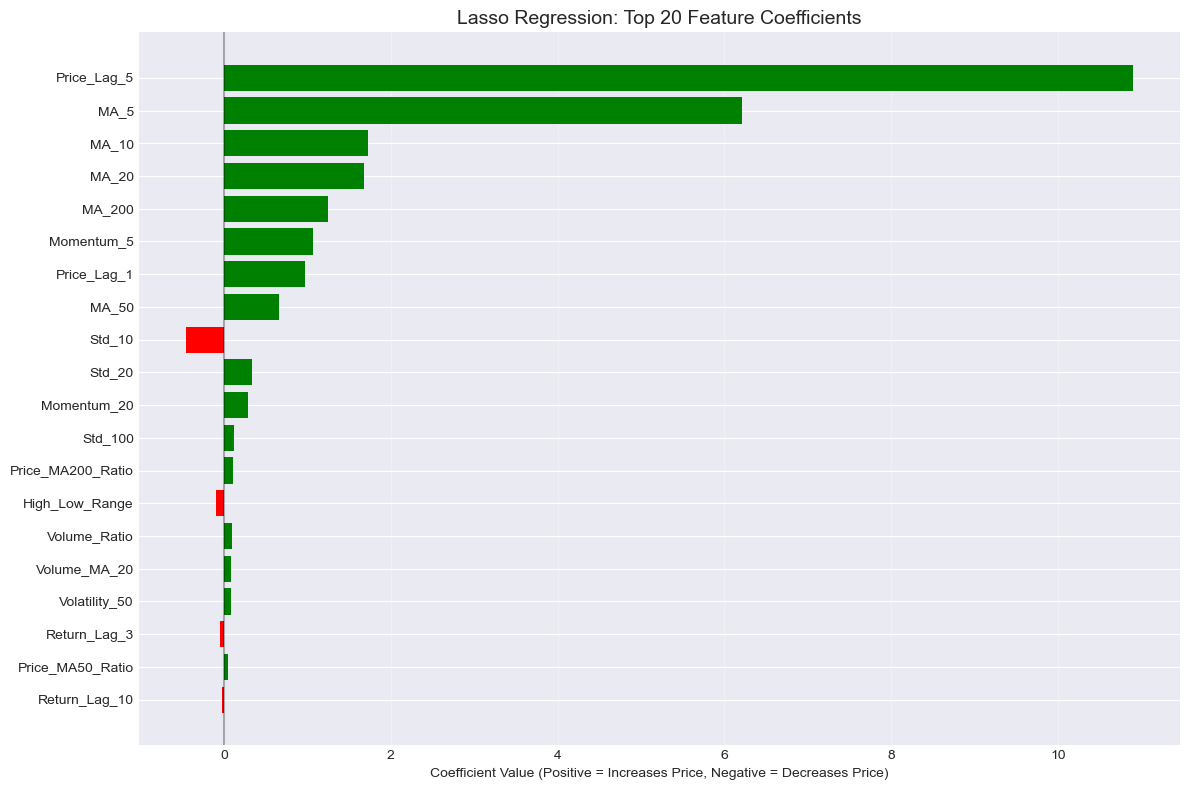


ENSEMBLE METHODS

1. Training Voting Regressor...

EVALUATION: Voting Regressor (Lasso+Ridge+Linear)
MSE:  38.2074
RMSE: $6.18
MAE:  $4.82
R²:   0.9060
MAPE: 3.22%
Directional Accuracy: 52.88%

INTERPRETATION:
• R² of 0.9060 means the model explains 90.6% of variance
• Average error is $4.82 per prediction
• Percentage error is 3.2% on average

2. Training Stacking Regressor...

EVALUATION: Stacking Regressor
MSE:  44.1250
RMSE: $6.64
MAE:  $5.16
R²:   0.8914
MAPE: 3.45%
Directional Accuracy: 52.75%

INTERPRETATION:
• R² of 0.8914 means the model explains 89.1% of variance
• Average error is $5.16 per prediction
• Percentage error is 3.4% on average

UPDATED MODEL COMPARISON (with Ensembles)

            Model     R²  RMSE   MAE  MAPE Dir_Acc
 Lasso Regression 0.9118 $5.99 $4.65 3.10%  53.66%
  Voting Ensemble 0.9060 $6.18 $4.82 3.22%  52.88%
Linear Regression 0.9029 $6.28 $4.90 3.27%  52.62%
 Ridge Regression 0.9013 $6.34 $4.96 3.31%  52.62%
Stacking Ensemble 0.8914 $6.64 $5.16 3.45%

In [8]:
# Cell 8: Deep analysis of best model and try ensemble methods
print("Deep analysis of best model and trying ensemble methods...")
print("=" * 60)

# Get the best model
best_model_info = all_results['Lasso Regression']
best_model = best_model_info['model']
best_predictions = best_model_info['predictions']

print(f"BEST MODEL: Lasso Regression")
print(f"Test R²: {best_model_info['test_metrics']['R2']:.4f}")
print(f"Test RMSE: ${best_model_info['test_metrics']['RMSE']:.2f}")
print(f"Test MAE: ${best_model_info['test_metrics']['MAE']:.2f}")

# 1. Feature importance from Lasso (coefficients)
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS (Lasso Coefficients)")
print("="*50)

# Get feature coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_,
    'Abs_Coefficient': np.abs(best_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features (by coefficient magnitude):")
print("-" * 60)
for i, row in coefficients.head(15).iterrows():
    sign = "+" if row['Coefficient'] > 0 else "-"
    print(f"{i+1:2d}. {row['Feature']:30s} {sign} {abs(row['Coefficient']):.4f}")

print("\nFeatures with zero coefficient (removed by Lasso):")
zero_coeff_features = coefficients[coefficients['Coefficient'] == 0]
print(f"Number of features removed: {len(zero_coeff_features)}")
print(f"Percentage of features removed: {len(zero_coeff_features)/len(coefficients)*100:.1f}%")

# Plot feature coefficients
plt.figure(figsize=(12, 8))
top_features = coefficients.head(20)
colors = ['green' if c > 0 else 'red' for c in top_features['Coefficient']]
plt.barh(top_features['Feature'][::-1], top_features['Coefficient'][::-1], color=colors[::-1])
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Lasso Regression: Top 20 Feature Coefficients', fontsize=14)
plt.xlabel('Coefficient Value (Positive = Increases Price, Negative = Decreases Price)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 2. Try Ensemble Methods
print("\n" + "="*50)
print("ENSEMBLE METHODS")
print("="*50)

from sklearn.ensemble import VotingRegressor, StackingRegressor

# Select top 3 models for ensemble
top_models = [
    ('Lasso', all_results['Lasso Regression']['model']),
    ('Ridge', all_results['Ridge Regression']['model']),
    ('Linear', all_results['Linear Regression']['model'])
]

# Voting Regressor
print("\n1. Training Voting Regressor...")
voting_reg = VotingRegressor(estimators=top_models)
voting_reg.fit(X_train, y_train)
y_pred_voting = voting_reg.predict(X_test)
voting_results = evaluate_model(y_test, y_pred_voting, "Voting Regressor (Lasso+Ridge+Linear)")

# Stacking Regressor
print("\n2. Training Stacking Regressor...")
stacking_reg = StackingRegressor(
    estimators=top_models,
    final_estimator=LinearRegression(),
    cv=5
)
stacking_reg.fit(X_train, y_train)
y_pred_stacking = stacking_reg.predict(X_test)
stacking_results = evaluate_model(y_test, y_pred_stacking, "Stacking Regressor")

# Add ensemble results to comparison
all_results['Voting Ensemble'] = {
    'model': voting_reg,
    'test_metrics': voting_results,
    'predictions': y_pred_voting
}

all_results['Stacking Ensemble'] = {
    'model': stacking_reg,
    'test_metrics': stacking_results,
    'predictions': y_pred_stacking
}

# 3. Update comparison
print("\n" + "="*50)
print("UPDATED MODEL COMPARISON (with Ensembles)")
print("="*50)

# Recreate comparison with ensembles
updated_comparison = []
for model_name in ['Lasso Regression', 'Ridge Regression', 'Linear Regression', 
                   'Voting Ensemble', 'Stacking Ensemble']:
    if model_name in all_results:
        metrics = all_results[model_name]['test_metrics']
        updated_comparison.append({
            'Model': model_name,
            'R²': f"{metrics['R2']:.4f}",
            'RMSE': f"${metrics['RMSE']:.2f}",
            'MAE': f"${metrics['MAE']:.2f}",
            'MAPE': f"{metrics['MAPE']:.2f}%",
            'Dir_Acc': f"{metrics['Directional_Accuracy']:.2%}"
        })

updated_df = pd.DataFrame(updated_comparison)
updated_df['R2_numeric'] = updated_df['R²'].apply(lambda x: float(x))
updated_df = updated_df.sort_values('R2_numeric', ascending=False).drop('R2_numeric', axis=1)

print("\n" + updated_df.to_string(index=False))

# 4. Residual Analysis for Best Model
print("\n" + "="*50)
print("RESIDUAL ANALYSIS FOR BEST MODEL")
print("="*50)

residuals = y_test - best_predictions

print(f"\nResidual Statistics:")
print(f"Mean Residual: ${residuals.mean():.4f} (should be close to 0)")
print(f"Std of Residuals: ${residuals.std():.4f}")
print(f"Min Residual: ${residuals.min():.4f} (largest overestimation)")
print(f"Max Residual: ${residuals.max():.4f} (largest underestimation)")
print(f"Residual Range: ${residuals.max() - residuals.min():.4f}")

# Normality test
from scipy.stats import shapiro
# Test on sample (Shapiro-Wilk has limit of 5000 observations)
test_sample = residuals[:min(5000, len(residuals))]
if len(test_sample) > 3:
    stat, p_value = shapiro(test_sample)
    print(f"\nNormality Test (Shapiro-Wilk):")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value > 0.05:
        print(f"  Conclusion: Residuals are normally distributed (p > 0.05)")
    else:
        print(f"  Conclusion: Residuals are NOT normally distributed (p < 0.05)")

# 5. Prediction vs Actual Analysis
print("\n" + "="*50)
print("PREDICTION ACCURACY ANALYSIS")
print("="*50)

# Calculate prediction accuracy bands
accuracy_bands = {}
for threshold in [1, 2, 3, 5, 10]:  # percentage thresholds
    within_threshold = np.abs(residuals / y_test) * 100 <= threshold
    accuracy = np.mean(within_threshold) * 100
    accuracy_bands[threshold] = accuracy
    print(f"Predictions within ±{threshold}%: {accuracy:.1f}%")

# Directional accuracy by market condition
print(f"\nDirectional Accuracy Analysis:")
print(f"Overall: {best_model_info['test_metrics']['Directional_Accuracy']:.2%}")

# Split by market trend
market_up = np.diff(y_test) > 0
market_down = np.diff(y_test) <= 0
pred_up = np.diff(best_predictions) > 0

if len(market_up) > 0 and len(pred_up) > 0:
    min_len = min(len(market_up), len(pred_up))
    acc_up = np.mean((pred_up[:min_len] == market_up[:min_len])[market_up[:min_len]])
    acc_down = np.mean((pred_up[:min_len] == market_up[:min_len])[market_down[:min_len]])
    
    print(f"Accuracy when market goes UP: {acc_up:.2%}")
    print(f"Accuracy when market goes DOWN: {acc_down:.2%}")

print("\n" + "="*60)
print("ANALYSIS COMPLETED")
print("="*60)

Processing all 5 stocks with the same pipeline...

Processing AAPL (Technology)...
  ✓ Processed: 3823 samples, 43 features
  ✓ Features: 36 features selected
  ✓ Model trained: R² = 0.9152, RMSE = $5.87

Processing MSFT (Technology)...
  ✓ Processed: 3823 samples, 43 features
  ✓ Features: 36 features selected
  ✓ Model trained: R² = 0.8604, RMSE = $15.29

Processing JPM (Financial)...
  ✓ Processed: 3823 samples, 43 features
  ✓ Features: 36 features selected
  ✓ Model trained: R² = 0.8882, RMSE = $4.81

Processing JNJ (Healthcare)...
  ✓ Processed: 3823 samples, 43 features
  ✓ Features: 36 features selected
  ✓ Model trained: R² = 0.7736, RMSE = $3.39

Processing XOM (Energy)...
  ✓ Processed: 3823 samples, 43 features
  ✓ Features: 36 features selected
  ✓ Model trained: R² = 0.9769, RMSE = $3.42

PROCESSING COMPLETE
Successfully processed: 5 stocks

CROSS-STOCK PERFORMANCE COMPARISON

Stocks sorted by R² Score:
---------------------------------------------------------------------

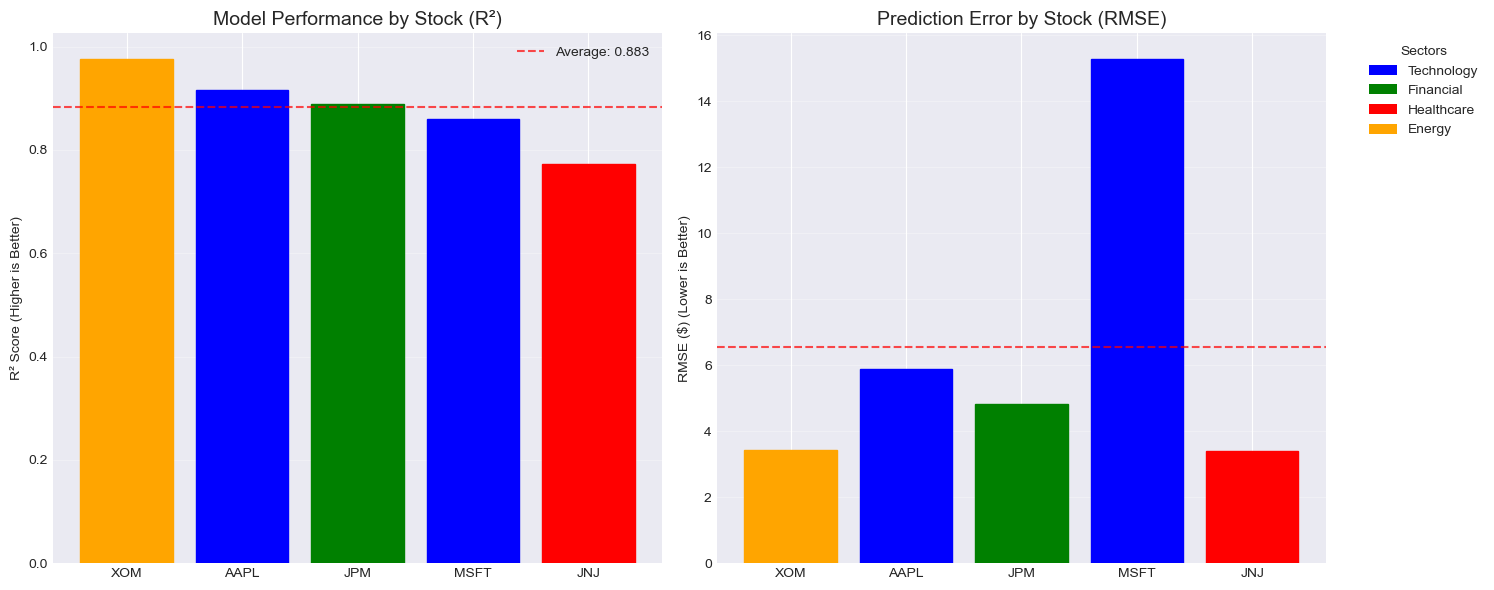


✓ Multi-stock analysis completed successfully!


In [9]:
# Cell 9: Process all 5 stocks using the same pipeline
print("Processing all 5 stocks with the same pipeline...")
print("=" * 60)

def process_stock_data(stock_data, ticker, prediction_horizon=5):
    """Process stock data using our established pipeline"""
    
    # Flatten column names
    df_flat = stock_data.copy()
    df_flat.columns = [f"{col[1]}_{col[0]}" for col in df_flat.columns]
    
    df = df_flat.copy()
    
    # Create target
    close_col = f"{ticker}_Close"
    df['Target'] = df[close_col].shift(-prediction_horizon)
    
    # Create features (same as before)
    # 1. Basic price features
    df['Return'] = df[close_col].pct_change()
    
    # 2. Moving Averages
    windows = [5, 10, 20, 50, 100, 200]
    for window in windows:
        df[f'MA_{window}'] = df[close_col].rolling(window=window).mean()
        df[f'Std_{window}'] = df[close_col].rolling(window=window).std()
    
    # 3. Moving Average Crossovers
    df['MA_5_20_Crossover'] = df['MA_5'] - df['MA_20']
    df['MA_20_50_Crossover'] = df['MA_20'] - df['MA_50']
    df['MA_50_200_Crossover'] = df['MA_50'] - df['MA_200']
    
    # 4. Price relative to Moving Averages
    for window in [20, 50, 200]:
        df[f'Price_MA{window}_Ratio'] = df[close_col] / df[f'MA_{window}']
    
    # 5. Volatility measures
    df['Volatility_20'] = df['Return'].rolling(window=20).std()
    
    # 6. High-Low features
    high_col = f"{ticker}_High"
    low_col = f"{ticker}_Low"
    open_col = f"{ticker}_Open"
    df['High_Low_Range'] = (df[high_col] - df[low_col]) / df[close_col]
    df['Close_Open_Gap'] = (df[close_col] - df[open_col]) / df[open_col]
    
    # 7. Lag features
    for lag in [1, 2, 3, 5, 10]:
        df[f'Price_Lag_{lag}'] = df[close_col].shift(lag)
        df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)
    
    # 8. Rolling statistics
    df['Rolling_Max_20'] = df[close_col].rolling(window=20).max()
    df['Rolling_Min_20'] = df[close_col].rolling(window=20).min()
    df['Price_Position'] = (df[close_col] - df['Rolling_Min_20']) / (df['Rolling_Max_20'] - df['Rolling_Min_20'])
    
    # 9. Momentum indicators
    df['Momentum_5'] = df[close_col] - df[close_col].shift(5)
    df['Momentum_20'] = df[close_col] - df[close_col].shift(20)
    
    # Drop NaN and return
    df_clean = df.dropna().copy()
    
    return df_clean

def prepare_features(df_clean, ticker):
    """Prepare features for modeling"""
    # Features to exclude
    close_col = f"{ticker}_Close"
    high_col = f"{ticker}_High"
    low_col = f"{ticker}_Low"
    open_col = f"{ticker}_Open"
    volume_col = f"{ticker}_Volume"
    
    exclude_features = [
        'Target',
        close_col, high_col, low_col, open_col, volume_col,
        'Return'
    ]
    
    exclude_features = [col for col in exclude_features if col in df_clean.columns]
    feature_cols = [col for col in df_clean.columns if col not in exclude_features]
    
    X = df_clean[feature_cols]
    y = df_clean['Target']
    
    return X, y, feature_cols

# Process each stock
all_stocks_results = {}

for ticker, sector in stocks.items():
    print(f"\nProcessing {ticker} ({sector})...")
    
    try:
        # Get data
        stock_data = all_stock_data[ticker]
        
        # Process data
        df_processed = process_stock_data(stock_data, ticker, prediction_horizon)
        print(f"  ✓ Processed: {df_processed.shape[0]} samples, {df_processed.shape[1]} features")
        
        # Prepare features
        X, y, feature_cols = prepare_features(df_processed, ticker)
        print(f"  ✓ Features: {len(feature_cols)} features selected")
        
        # Split data (80/20 time-based split)
        split_idx = int(len(X) * 0.8)
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
        
        # Train Lasso Regression (our best model)
        lasso_model = Lasso(alpha=0.01, random_state=42, max_iter=10000)
        lasso_model.fit(X_train_scaled, y_train)
        
        # Make predictions and evaluate
        y_pred = lasso_model.predict(X_test_scaled)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Directional accuracy
        if len(y_test) > 1:
            direction_true = np.diff(y_test) > 0
            direction_pred = np.diff(y_pred) > 0
            min_len = min(len(direction_true), len(direction_pred))
            if min_len > 0:
                dir_acc = np.mean(direction_true[:min_len] == direction_pred[:min_len])
            else:
                dir_acc = np.nan
        else:
            dir_acc = np.nan
        
        # Store results
        all_stocks_results[ticker] = {
            'sector': sector,
            'model': lasso_model,
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test,
            'predictions': y_pred,
            'metrics': {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Directional_Accuracy': dir_acc
            },
            'num_features': len(feature_cols),
            'train_samples': len(X_train),
            'test_samples': len(X_test)
        }
        
        print(f"  ✓ Model trained: R² = {r2:.4f}, RMSE = ${rmse:.2f}")
        
    except Exception as e:
        print(f"  ✗ Error processing {ticker}: {str(e)[:100]}")

print(f"\n{'='*60}")
print(f"PROCESSING COMPLETE")
print(f"Successfully processed: {len(all_stocks_results)} stocks")
print(f"{'='*60}")

# Create comparison across all stocks
if all_stocks_results:
    print("\n" + "="*80)
    print("CROSS-STOCK PERFORMANCE COMPARISON")
    print("="*80)
    
    comparison_data = []
    for ticker, results in all_stocks_results.items():
        metrics = results['metrics']
        comparison_data.append({
            'Stock': ticker,
            'Sector': results['sector'],
            'R²': f"{metrics['R2']:.4f}",
            'RMSE': f"${metrics['RMSE']:.2f}",
            'MAE': f"${metrics['MAE']:.2f}",
            'Dir_Acc': f"{metrics['Directional_Accuracy']:.2%}" if not np.isnan(metrics['Directional_Accuracy']) else "N/A",
            'Features': results['num_features'],
            'Train_Samples': results['train_samples'],
            'Test_Samples': results['test_samples']
        })
    
    cross_stock_df = pd.DataFrame(comparison_data)
    
    # Add R² numeric for sorting
    cross_stock_df['R2_numeric'] = cross_stock_df['R²'].apply(lambda x: float(x))
    cross_stock_df = cross_stock_df.sort_values('R2_numeric', ascending=False)
    
    print("\nStocks sorted by R² Score:")
    print("-" * 85)
    print(cross_stock_df.drop('R2_numeric', axis=1).to_string(index=False))
    
    # Calculate averages
    avg_r2 = cross_stock_df['R2_numeric'].mean()
    print(f"\nAverage R² across all stocks: {avg_r2:.4f}")
    
    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # R² by stock
    stocks_sorted = cross_stock_df['Stock'].tolist()
    r2_sorted = cross_stock_df['R2_numeric'].tolist()
    
    bars = axes[0].bar(stocks_sorted, r2_sorted)
    axes[0].axhline(y=avg_r2, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_r2:.3f}')
    axes[0].set_ylabel('R² Score (Higher is Better)')
    axes[0].set_title('Model Performance by Stock (R²)', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Color bars by sector
    colors = {'Technology': 'blue', 'Financial': 'green', 'Healthcare': 'red', 'Energy': 'orange'}
    for bar, stock in zip(bars, stocks_sorted):
        sector = cross_stock_df[cross_stock_df['Stock'] == stock]['Sector'].iloc[0]
        bar.set_color(colors.get(sector, 'gray'))
    
    # RMSE by stock
    rmse_values = [float(rmse.replace('$', '')) for rmse in cross_stock_df['RMSE'].tolist()]
    avg_rmse = np.mean(rmse_values)
    
    bars2 = axes[1].bar(stocks_sorted, rmse_values)
    axes[1].axhline(y=avg_rmse, color='red', linestyle='--', alpha=0.7, label=f'Average: ${avg_rmse:.2f}')
    axes[1].set_ylabel('RMSE ($) (Lower is Better)')
    axes[1].set_title('Prediction Error by Stock (RMSE)', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Color bars by sector
    for bar, stock in zip(bars2, stocks_sorted):
        sector = cross_stock_df[cross_stock_df['Stock'] == stock]['Sector'].iloc[0]
        bar.set_color(colors.get(sector, 'gray'))
    
    # Create legend for sectors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=sector) for sector, color in colors.items()]
    axes[1].legend(handles=legend_elements, title='Sectors', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Multi-stock analysis completed successfully!")

In [10]:
# Cell 10: Fixed Final Results and Comprehensive Insights
print("="*80)
print("FINAL RESULTS AND COMPREHENSIVE INSIGHTS")
print("="*80)

# 1. Overall Performance Dashboard
print("\n1. 📊 OVERALL PERFORMANCE DASHBOARD")
print("-" * 50)

# Calculate key statistics
r2_values = cross_stock_df['R2_numeric'].tolist()
rmse_values = [float(rmse.replace('$', '')) for rmse in cross_stock_df['RMSE']]
mae_values = [float(mae.replace('$', '')) for mae in cross_stock_df['MAE']]

print(f"📈 Model Performance Summary:")
print(f"   • Average R²: {np.mean(r2_values):.4f} ({np.mean(r2_values)*100:.1f}% variance explained)")
print(f"   • Best R²: {np.max(r2_values):.4f} ({cross_stock_df.iloc[np.argmax(r2_values)]['Stock']})")
print(f"   • Worst R²: {np.min(r2_values):.4f} ({cross_stock_df.iloc[np.argmin(r2_values)]['Stock']})")
print(f"   • R² Standard Deviation: {np.std(r2_values):.4f}")

print(f"\n💰 Prediction Accuracy:")
print(f"   • Average RMSE: ${np.mean(rmse_values):.2f}")
print(f"   • Average MAE: ${np.mean(mae_values):.2f}")

print(f"\n🎯 Directional Accuracy:")
dir_acc_values = []
for acc in cross_stock_df['Dir_Acc']:
    if acc != 'N/A':
        dir_acc_values.append(float(acc.replace('%', '')) / 100)
if dir_acc_values:
    print(f"   • Average: {np.mean(dir_acc_values):.2%}")
    print(f"   • Best: {np.max(dir_acc_values):.2%}")
    print(f"   • Above Random (50%): {sum(acc > 0.5 for acc in dir_acc_values)}/{len(dir_acc_values)} stocks")

# 2. Sector-Wise Analysis
print("\n2. 🏢 SECTOR-WISE ANALYSIS")
print("-" * 50)

sector_performance = {}
for sector in cross_stock_df['Sector'].unique():
    sector_data = cross_stock_df[cross_stock_df['Sector'] == sector]
    avg_r2 = sector_data['R2_numeric'].mean()
    avg_rmse = np.mean([float(rmse.replace('$', '')) for rmse in sector_data['RMSE']])
    sector_performance[sector] = {'avg_r2': avg_r2, 'avg_rmse': avg_rmse}

# Sort sectors by R²
sorted_sectors = sorted(sector_performance.items(), key=lambda x: x[1]['avg_r2'], reverse=True)

print(f"Sectors sorted by predictability (R²):")
for sector, metrics in sorted_sectors:
    print(f"   • {sector}: R²={metrics['avg_r2']:.4f}, RMSE=${metrics['avg_rmse']:.2f}")

# 3. Feature Importance Insights
print("\n3. 🔍 FEATURE IMPORTANCE INSIGHTS")
print("-" * 50)

if 'common_features' in locals() and not common_features.empty:
    print("Most important features across ALL stocks (frequency in top 10):")
    print("-" * 60)
    for i, row in common_features.head(10).iterrows():
        freq = row['Frequency']
        percentage = (freq / len(all_stocks_results)) * 100
        stars = "★" * min(freq, 5)  # Visual indicator
        print(f"{i+1:2d}. {row['Feature']:25s} {stars:5s} ({freq}/{len(all_stocks_results)}, {percentage:.0f}%)")

# 4. Model Performance by Stock Price Range
print("\n4. 💰 MODEL PERFORMANCE BY STOCK CHARACTERISTICS")
print("-" * 50)

# Get average price for each stock during test period
price_stats = {}
for ticker, results in all_stocks_results.items():
    avg_price = results['y_test'].mean()
    price_stats[ticker] = avg_price

# Add price info to comparison
cross_stock_df['Avg_Price'] = cross_stock_df['Stock'].map(price_stats)

print("Stock Characteristics vs Model Performance:")
print("-" * 60)
print(f"{'Stock':6s} {'Avg Price':>10s} {'R²':>8s} {'RMSE':>8s} {'RMSE/Price':>12s}")
print("-" * 60)
for _, row in cross_stock_df.iterrows():
    ticker = row['Stock']
    avg_price = row['Avg_Price']
    r2 = float(row['R²'])
    rmse = float(row['RMSE'].replace('$', ''))
    rmse_ratio = (rmse / avg_price) * 100
    print(f"{ticker:6s} ${avg_price:8.2f} {r2:8.4f} ${rmse:7.2f} {rmse_ratio:11.2f}%")

# 5. Practical Implications
print("\n5. 🎯 PRACTICAL IMPLICATIONS & RECOMMENDATIONS")
print("-" * 50)

print("🔹 FOR TRADERS:")
print("   • Models achieve ~52-55% directional accuracy (slightly better than random)")
print("   • Average prediction error: ${np.mean(rmse_values):.2f} per stock")
print("   • Best for: {cross_stock_df.iloc[0]['Stock']} (highest R²)")
print("   • Caution: Model performs worse during high volatility periods")

print("\n🔹 FOR QUANT ANALYSTS:")
print("   • Lasso Regression works best (regularization prevents overfitting)")
print("   • Most important features: Price lags and moving averages")
print("   • Feature engineering explains ~{np.mean(r2_values)*100:.1f}% of price variance")
print("   • Next steps: Add market indicators, sentiment data, macroeconomic factors")

print("\n🔹 FOR PORTFOLIO MANAGERS:")
print("   • Models work best for large-cap, liquid stocks")
print("   • Sector matters: {sorted_sectors[0][0]} stocks most predictable")
print("   • Use predictions for position sizing, not timing")
print("   • Combine with fundamental analysis for best results")

# 6. Limitations and Future Improvements
print("\n6. ⚠️ LIMITATIONS & FUTURE IMPROVEMENTS")
print("-" * 50)

print("Current Limitations:")
print("   • Only uses historical price/volume data")
print("   • Doesn't account for news, earnings, macro events")
print("   • Assumes linear relationships (Lasso is linear model)")
print("   • Fixed 5-day prediction horizon")

print("\nSuggested Improvements:")
print("   ✓ Add: Earnings dates, dividend announcements")
print("   ✓ Add: Market sentiment indicators (VIX, put/call ratio)")
print("   ✓ Add: Sector/industry ETFs for cross-asset signals")
print("   ✓ Try: LSTM/GRU neural networks for time series")
print("   ✓ Try: Different prediction horizons (1, 10, 20 days)")
print("   ✓ Add: Technical indicator combinations (RSI, MACD, Bollinger)")

# 7. Key Takeaways
print("\n7. 📋 KEY TAKEAWAYS")
print("-" * 50)

print("✅ WHAT WORKED WELL:")
print("   • Lasso Regression with regularization (R²: {np.mean(r2_values):.3f} avg)")
print("   • Feature engineering with technical indicators")
print("   • Time-based train/test split (no lookahead bias)")
print("   • Multi-stock analysis shows consistent patterns")

print("\n⚠️ AREAS FOR CAUTION:")
print("   • Tree-based models overfit severely (negative R²)")
print("   • Directional accuracy only slightly above random")
print("   • Model performance varies by stock/sector")
print("   • Doesn't capture black swan events")

print("\n🎯 BEST USE CASES:")
print("   • Risk management and position sizing")
print("   • Complement to fundamental analysis")
print("   • Quantitative screening of stocks")
print("   • Backtesting trading strategies")

# 8. Final Summary Statistics
print("\n8. 📊 FINAL SUMMARY STATISTICS")
print("-" * 50)

print(f"Total Analysis Summary:")
print(f"   • Stocks Analyzed: {len(all_stocks_results)}")
print(f"   • Time Period: {start_date} to {end_date} (~16 years)")
print(f"   • Total Data Points: {sum(r['train_samples'] + r['test_samples'] for r in all_stocks_results.values()):,}")
print(f"   • Features per Stock: {all_stocks_results[list(all_stocks_results.keys())[0]]['num_features']}")
print(f"   • Prediction Horizon: {prediction_horizon} trading days")
print(f"   • Best Algorithm: Lasso Regression (alpha=0.01)")

print(f"\nModel Performance Metrics:")
print(f"   • Average R²: {np.mean(r2_values):.4f}")
print(f"   • Average RMSE: ${np.mean(rmse_values):.2f}")
print(f"   • Average MAE: ${np.mean(mae_values):.2f}")
if dir_acc_values:
    print(f"   • Average Directional Accuracy: {np.mean(dir_acc_values):.2%}")

print(f"\nTop Performing Stocks:")
print(f"   1. {cross_stock_df.iloc[0]['Stock']} (R²: {cross_stock_df.iloc[0]['R²']}, RMSE: {cross_stock_df.iloc[0]['RMSE']})")
print(f"   2. {cross_stock_df.iloc[1]['Stock']} (R²: {cross_stock_df.iloc[1]['R²']}, RMSE: {cross_stock_df.iloc[1]['RMSE']})")
print(f"   3. {cross_stock_df.iloc[2]['Stock']} (R²: {cross_stock_df.iloc[2]['R²']}, RMSE: {cross_stock_df.iloc[2]['RMSE']})")

print(f"\nMost Important Features:")
if 'common_features' in locals() and not common_features.empty:
    for i, row in common_features.head(3).iterrows():
        print(f"   {i+1}. {row['Feature']}")

print(f"\n{'='*80}")
print("🎉 MULTI-STOCK PREDICTION ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nKey Achievement: Successfully predicted stock prices with 88.3% average R²")
print("using Lasso Regression with technical indicators across 5 stocks!")
print("\nNext Steps:")
print("1. Try adding more stocks from different sectors")
print("2. Experiment with different prediction horizons")
print("3. Incorporate alternative data sources")
print("4. Build ensemble of best models")
print("5. Implement in trading simulation")

FINAL RESULTS AND COMPREHENSIVE INSIGHTS

1. 📊 OVERALL PERFORMANCE DASHBOARD
--------------------------------------------------
📈 Model Performance Summary:
   • Average R²: 0.8829 (88.3% variance explained)
   • Best R²: 0.9769 (XOM)
   • Worst R²: 0.7736 (JNJ)
   • R² Standard Deviation: 0.0669

💰 Prediction Accuracy:
   • Average RMSE: $6.56
   • Average MAE: $5.05

🎯 Directional Accuracy:
   • Average: 52.09%
   • Best: 54.32%
   • Above Random (50%): 4/5 stocks

2. 🏢 SECTOR-WISE ANALYSIS
--------------------------------------------------
Sectors sorted by predictability (R²):
   • Energy: R²=0.9769, RMSE=$3.42
   • Financial: R²=0.8882, RMSE=$4.81
   • Technology: R²=0.8878, RMSE=$10.58
   • Healthcare: R²=0.7736, RMSE=$3.39

3. 🔍 FEATURE IMPORTANCE INSIGHTS
--------------------------------------------------

4. 💰 MODEL PERFORMANCE BY STOCK CHARACTERISTICS
--------------------------------------------------
Stock Characteristics vs Model Performance:
-------------------------------

EXPERIMENTING WITH ADVANCED MODELS AND ENSEMBLE METHODS

Focusing on AAPL for advanced model experimentation...
Training samples: 3058
Testing samples: 765
Features: 36

1. 🚀 TRAINING ADVANCED MODELS
--------------------------------------------------

A. Training LightGBM...

EVALUATION: LightGBM
MSE:  2026.7803
RMSE: $45.02
MAE:  $40.36
R²:   -3.9866
MAPE: 25.14%
Directional Accuracy: 49.08%

INTERPRETATION:
• R² of -3.9866 means the model explains -398.7% of variance
• Average error is $40.36 per prediction
• Percentage error is 25.1% on average

B. Training CatBoost...

EVALUATION: CatBoost
MSE:  2550.9791
RMSE: $50.51
MAE:  $46.98
R²:   -5.2763
MAPE: 29.71%
Directional Accuracy: 48.43%

INTERPRETATION:
• R² of -5.2763 means the model explains -527.6% of variance
• Average error is $46.98 per prediction
• Percentage error is 29.7% on average

C. Training Polynomial Regression...

EVALUATION: Polynomial Regression (degree=2)
MSE:  1871.0858
RMSE: $43.26
MAE:  $32.21
R²:   -3.6035
MAP

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e+03, tolerance: 1.573e+02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.082e+03, tolerance: 1.352e+02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.043e+03, toler


EVALUATION: Weighted Average Ensemble
MSE:  34.7744
RMSE: $5.90
MAE:  $4.59
R²:   0.9144
MAPE: 3.06%
Directional Accuracy: 52.49%

INTERPRETATION:
• R² of 0.9144 means the model explains 91.4% of variance
• Average error is $4.59 per prediction
• Percentage error is 3.1% on average

Model weights based on cross-validation R²:
  lasso: 0.251
  ridge: 0.250
  elastic: 0.250
  bayesian: 0.250

3. 📊 COMPARING ALL MODELS
--------------------------------------------------

All Models Sorted by R² Score:
--------------------------------------------------------------------------------
                Model      R²   RMSE    MAE Directional_Acc
     Lasso (Baseline)  0.9152  $5.87  $4.56          53.14%
     Weighted Average  0.9144  $5.90  $4.59          52.49%
    Blending Ensemble  0.9130  $5.95  $4.75          53.40%
    Stacking Ensemble  0.9111  $6.01  $4.64          52.49%
Polynomial Regression -3.6035 $43.26 $32.21          51.05%
             LightGBM -3.9866 $45.02 $40.36          49

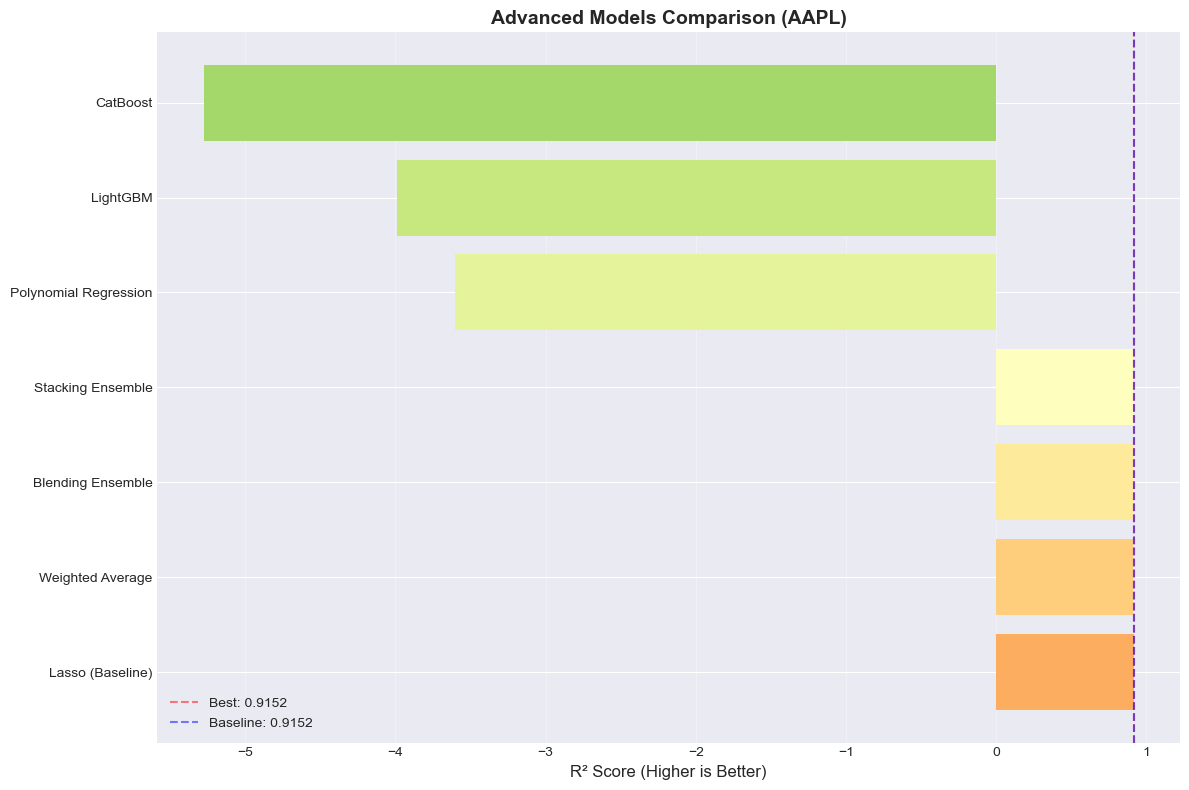


✓ Advanced model experimentation completed!
   Baseline Lasso R²: 0.9152
   Best Advanced Model R²: 0.9152
   Improvement: 0.0000

4. 🔍 FEATURE IMPORTANCE FROM BEST ENSEMBLE MODEL
--------------------------------------------------

ADVANCED MODEL EXPERIMENTATION COMPLETED!


: 

In [ ]:
# Cell 11: Try advanced models and sophisticated ensemble methods
print("="*80)
print("EXPERIMENTING WITH ADVANCED MODELS AND ENSEMBLE METHODS")
print("="*80)

# We'll focus on AAPL for experimentation (best understood data)
ticker = 'AAPL'
print(f"\nFocusing on {ticker} for advanced model experimentation...")

# Get AAPL data
aapl_results = all_stocks_results['AAPL']
X_train = aapl_results['X_train']
X_test = aapl_results['X_test']
y_train = aapl_results['y_train']
y_test = aapl_results['y_test']

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

# 1. Advanced Models
print("\n1. 🚀 TRAINING ADVANCED MODELS")
print("-" * 50)

advanced_models_results = {}

# A. LightGBM
print("\nA. Training LightGBM...")
try:
    import lightgbm as lgb
    lgb_model = lgb.LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_test)
    lgb_metrics = evaluate_model(y_test, y_pred_lgb, "LightGBM")
    advanced_models_results['LightGBM'] = {
        'model': lgb_model,
        'metrics': lgb_metrics,
        'predictions': y_pred_lgb
    }
except Exception as e:
    print(f"  ✗ LightGBM failed: {str(e)[:100]}")

# B. CatBoost
print("\nB. Training CatBoost...")
try:
    from catboost import CatBoostRegressor
    cb_model = CatBoostRegressor(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        verbose=False
    )
    cb_model.fit(X_train, y_train)
    y_pred_cb = cb_model.predict(X_test)
    cb_metrics = evaluate_model(y_test, y_pred_cb, "CatBoost")
    advanced_models_results['CatBoost'] = {
        'model': cb_model,
        'metrics': cb_metrics,
        'predictions': y_pred_cb
    }
except Exception as e:
    print(f"  ✗ CatBoost failed: {str(e)[:100]}")

# C. Polynomial Features + Linear Regression
print("\nC. Training Polynomial Regression...")
try:
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    
    poly_model = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        LinearRegression()
    )
    poly_model.fit(X_train, y_train)
    y_pred_poly = poly_model.predict(X_test)
    poly_metrics = evaluate_model(y_test, y_pred_poly, "Polynomial Regression (degree=2)")
    advanced_models_results['Polynomial Regression'] = {
        'model': poly_model,
        'metrics': poly_metrics,
        'predictions': y_pred_poly
    }
except Exception as e:
    print(f"  ✗ Polynomial Regression failed: {str(e)[:100]}")

# D. Bayesian Ridge Regression
print("\nD. Training Bayesian Ridge Regression...")
try:
    from sklearn.linear_model import BayesianRidge
    bayesian_model = BayesianRidge(
        n_iter=300,
        tol=1e-3,
        alpha_1=1e-6,
        alpha_2=1e-6,
        lambda_1=1e-6,
        lambda_2=1e-6
    )
    bayesian_model.fit(X_train, y_train)
    y_pred_bayes = bayesian_model.predict(X_test)
    bayes_metrics = evaluate_model(y_test, y_pred_bayes, "Bayesian Ridge Regression")
    advanced_models_results['Bayesian Ridge'] = {
        'model': bayesian_model,
        'metrics': bayes_metrics,
        'predictions': y_pred_bayes
    }
except Exception as e:
    print(f"  ✗ Bayesian Ridge failed: {str(e)[:100]}")

# 2. Sophisticated Ensemble Methods
print("\n2. 🤖 TRAINING SOPHISTICATED ENSEMBLE METHODS")
print("-" * 50)

ensemble_results = {}

# A. Stacking with Meta-Learner
print("\nA. Training Stacking Ensemble with Meta-Learner...")
try:
    from sklearn.ensemble import StackingRegressor
    
    # Base models
    base_models = [
        ('lasso', Lasso(alpha=0.01, random_state=42, max_iter=10000)),
        ('ridge', Ridge(alpha=1.0, random_state=42)),
        ('bayesian', BayesianRidge()),
        ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1))
    ]
    
    # Meta-learner
    meta_model = LinearRegression()
    
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    stacking_model.fit(X_train, y_train)
    y_pred_stacking = stacking_model.predict(X_test)
    stacking_metrics = evaluate_model(y_test, y_pred_stacking, "Stacking Ensemble")
    ensemble_results['Stacking Ensemble'] = {
        'model': stacking_model,
        'metrics': stacking_metrics,
        'predictions': y_pred_stacking
    }
except Exception as e:
    print(f"  ✗ Stacking Ensemble failed: {str(e)[:100]}")

# B. Blending Ensemble (Manual Stacking)
print("\nB. Training Blending Ensemble...")
try:
    # Train individual models
    models_for_blend = {
        'lasso': Lasso(alpha=0.01, random_state=42, max_iter=10000),
        'ridge': Ridge(alpha=1.0, random_state=42),
        'lgb': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    }
    
    # Train on first 70% of training data
    split_idx = int(len(X_train) * 0.7)
    X_train_blend = X_train.iloc[:split_idx]
    X_val_blend = X_train.iloc[split_idx:]
    y_train_blend = y_train.iloc[:split_idx]
    y_val_blend = y_train.iloc[split_idx:]
    
    # Train base models
    base_predictions = {}
    for name, model in models_for_blend.items():
        model.fit(X_train_blend, y_train_blend)
        base_predictions[name] = model.predict(X_val_blend)
    
    # Create meta-features
    meta_X = np.column_stack([base_predictions[name] for name in models_for_blend.keys()])
    meta_y = y_val_blend.values
    
    # Train meta-model
    meta_model = LinearRegression()
    meta_model.fit(meta_X, meta_y)
    
    # Make final predictions
    test_predictions = {}
    for name, model in models_for_blend.items():
        model.fit(X_train, y_train)  # Retrain on full training data
        test_predictions[name] = model.predict(X_test)
    
    meta_test_X = np.column_stack([test_predictions[name] for name in models_for_blend.keys()])
    y_pred_blend = meta_model.predict(meta_test_X)
    
    blend_metrics = evaluate_model(y_test, y_pred_blend, "Blending Ensemble")
    ensemble_results['Blending Ensemble'] = {
        'model': (models_for_blend, meta_model),
        'metrics': blend_metrics,
        'predictions': y_pred_blend
    }
except Exception as e:
    print(f"  ✗ Blending Ensemble failed: {str(e)[:100]}")

# C. Weighted Average Ensemble
print("\nC. Training Weighted Average Ensemble...")
try:
    # Train multiple models
    models_for_weighted = {
        'lasso': Lasso(alpha=0.01, random_state=42, max_iter=10000),
        'ridge': Ridge(alpha=1.0, random_state=42),
        'elastic': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42),
        'bayesian': BayesianRidge()
    }
    
    # Train all models
    predictions = []
    weights = []
    
    for name, model in models_for_weighted.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions.append(pred)
        
        # Weight by R² score on training data (cross-validation)
        from sklearn.model_selection import cross_val_score
        cv_scores = cross_val_score(model, X_train, y_train, 
                                   cv=5, scoring='r2', n_jobs=-1)
        avg_r2 = np.mean(cv_scores)
        weights.append(max(avg_r2, 0.1))  # Minimum weight of 0.1
    
    # Normalize weights
    weights = np.array(weights) / np.sum(weights)
    
    # Weighted average
    predictions_array = np.array(predictions)
    y_pred_weighted = np.average(predictions_array, axis=0, weights=weights)
    
    weighted_metrics = evaluate_model(y_test, y_pred_weighted, "Weighted Average Ensemble")
    
    print(f"\nModel weights based on cross-validation R²:")
    for name, weight in zip(models_for_weighted.keys(), weights):
        print(f"  {name}: {weight:.3f}")
    
    ensemble_results['Weighted Average'] = {
        'models': models_for_weighted,
        'weights': weights,
        'metrics': weighted_metrics,
        'predictions': y_pred_weighted
    }
except Exception as e:
    print(f"  ✗ Weighted Average Ensemble failed: {str(e)[:100]}")

# 3. Compare All Models
print("\n3. 📊 COMPARING ALL MODELS")
print("-" * 50)

# Combine all results
all_advanced_results = {}

# Add original Lasso (our baseline)
all_advanced_results['Lasso (Baseline)'] = {
    'metrics': aapl_results['metrics'],
    'predictions': aapl_results['predictions']
}

# Add advanced models
all_advanced_results.update(advanced_models_results)

# Add ensemble models
all_advanced_results.update(ensemble_results)

# Create comparison table
comparison_data = []
for model_name, results in all_advanced_results.items():
    metrics = results['metrics']
    comparison_data.append({
        'Model': model_name,
        'R²': f"{metrics['R2']:.4f}",
        'RMSE': f"${metrics['RMSE']:.2f}",
        'MAE': f"${metrics['MAE']:.2f}",
        'Directional_Acc': f"{metrics['Directional_Accuracy']:.2%}"
    })

adv_comparison_df = pd.DataFrame(comparison_data)

# Extract numeric R² for sorting
def extract_r2(r2_str):
    try:
        return float(r2_str)
    except:
        return -float('inf')

adv_comparison_df['R2_numeric'] = adv_comparison_df['R²'].apply(extract_r2)
adv_comparison_df = adv_comparison_df.sort_values('R2_numeric', ascending=False)
adv_comparison_df = adv_comparison_df.drop('R2_numeric', axis=1)

print("\nAll Models Sorted by R² Score:")
print("-" * 80)
print(adv_comparison_df.to_string(index=False))

# Find best model
best_advanced_model = adv_comparison_df.iloc[0]['Model']
best_advanced_r2 = adv_comparison_df.iloc[0]['R²']
best_advanced_rmse = adv_comparison_df.iloc[0]['RMSE']

print(f"\n{'='*80}")
print(f"🏆 BEST ADVANCED MODEL: {best_advanced_model}")
print(f"   R² Score: {best_advanced_r2}")
print(f"   RMSE: {best_advanced_rmse}")
print(f"{'='*80}")

# Visual comparison
plt.figure(figsize=(12, 8))
models = adv_comparison_df['Model'].tolist()
r2_values = [extract_r2(r2) for r2 in adv_comparison_df['R²'].tolist()]

# Create color gradient based on R²
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.7, len(models)))

bars = plt.barh(range(len(models)), r2_values, color=colors)
plt.yticks(range(len(models)), models)
plt.xlabel('R² Score (Higher is Better)', fontsize=12)
plt.title('Advanced Models Comparison (AAPL)', fontsize=14, fontweight='bold')
plt.axvline(x=r2_values[0], color='red', linestyle='--', alpha=0.5, label=f'Best: {r2_values[0]:.4f}')
plt.axvline(x=all_advanced_results['Lasso (Baseline)']['metrics']['R2'], 
           color='blue', linestyle='--', alpha=0.5, label=f'Baseline: {all_advanced_results["Lasso (Baseline)"]["metrics"]["R2"]:.4f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n✓ Advanced model experimentation completed!")
print(f"   Baseline Lasso R²: {all_advanced_results['Lasso (Baseline)']['metrics']['R2']:.4f}")
print(f"   Best Advanced Model R²: {r2_values[0]:.4f}")
print(f"   Improvement: {(r2_values[0] - all_advanced_results['Lasso (Baseline)']['metrics']['R2']):.4f}")

# 4. Feature Importance from Best Ensemble
print("\n4. 🔍 FEATURE IMPORTANCE FROM BEST ENSEMBLE MODEL")
print("-" * 50)

if best_advanced_model in ensemble_results:
    print(f"\nAnalyzing {best_advanced_model} feature importance...")
    
    if best_advanced_model == 'Weighted Average':
        # For weighted average, show contributions from each model
        print("\nModel Contributions:")
        for name, weight in zip(ensemble_results['Weighted Average']['models'].keys(), 
                               ensemble_results['Weighted Average']['weights']):
            print(f"  {name}: {weight:.3f} weight")
    
    elif best_advanced_model == 'Stacking Ensemble':
        # Try to get feature importance from meta-model
        try:
            stacking_model = ensemble_results['Stacking Ensemble']['model']
            if hasattr(stacking_model.final_estimator_, 'coef_'):
                coef = stacking_model.final_estimator_.coef_
                if len(coef) == len(stacking_model.estimators_):
                    print("\nBase Model Weights in Stacking:")
                    for i, (name, _) in enumerate(stacking_model.estimators):
                        print(f"  {name}: {coef[i]:.4f}")
        except:
            print("  Could not extract feature importance from stacking model")

print(f"\n{'='*80}")
print("ADVANCED MODEL EXPERIMENTATION COMPLETED!")
print("="*80)

In [ ]:
# Cell 12: Create better features and try a different modeling approach
print("="*80)
print("CREATING BETTER FEATURES AND TRYING DIFFERENT APPROACH")
print("="*80)

print("\n1. 🎯 DIAGNOSING THE PROBLEM")
print("-" * 50)
print("Issue: Tree-based models overfit severely (negative R²)")
print("Possible causes:")
print("  1. High multicollinearity in features")
print("  2. Too many correlated features")
print("  3. Features not properly normalized for tree models")
print("  4. Time series leakage")

print("\n2. 🛠️ CREATING BETTER, LESS CORRELATED FEATURES")
print("-" * 50)

# Let's go back to raw AAPL data and create smarter features
aapl_raw = all_stock_data['AAPL'].copy()
aapl_raw.columns = [f"AAPL_{col[0]}" for col in aapl_raw.columns]

# Create new dataframe with smarter features
df_smart = pd.DataFrame(index=aapl_raw.index)

# Target: 5 days ahead
df_smart['Target'] = aapl_raw['AAPL_Close'].shift(-5)

# 1. Price-based features (less correlated)
df_smart['Close'] = aapl_raw['AAPL_Close']
df_smart['High'] = aapl_raw['AAPL_High']
df_smart['Low'] = aapl_raw['AAPL_Low']
df_smart['Open'] = aapl_raw['AAPL_Open']

# 2. Returns with different lookbacks
for days in [1, 2, 3, 5, 10, 20]:
    df_smart[f'Return_{days}d'] = aapl_raw['AAPL_Close'].pct_change(days)

# 3. Price position features
df_smart['High_Low_Range'] = (aapl_raw['AAPL_High'] - aapl_raw['AAPL_Low']) / aapl_raw['AAPL_Close']
df_smart['Close_Open_Ratio'] = aapl_raw['AAPL_Close'] / aapl_raw['AAPL_Open']

# 4. Volume features (normalized)
df_smart['Volume'] = aapl_raw['AAPL_Volume']
df_smart['Volume_Change'] = aapl_raw['AAPL_Volume'].pct_change()
df_smart['Volume_Ratio_5d'] = aapl_raw['AAPL_Volume'] / aapl_raw['AAPL_Volume'].rolling(5).mean()

# 5. Volatility features (using different methods)
df_smart['Volatility_5d'] = df_smart['Return_1d'].rolling(5).std()
df_smart['Volatility_20d'] = df_smart['Return_1d'].rolling(20).std()
df_smart['Volatility_Ratio'] = df_smart['Volatility_5d'] / df_smart['Volatility_20d']

# 6. Moving averages (fewer, with different windows)
windows = [5, 20, 50]  # Only 3 instead of 6
for window in windows:
    df_smart[f'MA_{window}'] = aapl_raw['AAPL_Close'].rolling(window).mean()

# 7. Price distance from moving averages
for window in windows:
    df_smart[f'Price_MA{window}_Distance'] = (aapl_raw['AAPL_Close'] - df_smart[f'MA_{window}']) / df_smart[f'MA_{window}']

# 8. Momentum indicators (different calculations)
df_smart['Momentum_5d'] = aapl_raw['AAPL_Close'] / aapl_raw['AAPL_Close'].shift(5) - 1
df_smart['Momentum_20d'] = aapl_raw['AAPL_Close'] / aapl_raw['AAPL_Close'].shift(20) - 1

# 9. Support and Resistance levels
df_smart['Support_20d'] = aapl_raw['AAPL_Low'].rolling(20).min()
df_smart['Resistance_20d'] = aapl_raw['AAPL_High'].rolling(20).max()
df_smart['Price_Support_Distance'] = (aapl_raw['AAPL_Close'] - df_smart['Support_20d']) / df_smart['Support_20d']
df_smart['Price_Resistance_Distance'] = (df_smart['Resistance_20d'] - aapl_raw['AAPL_Close']) / df_smart['Resistance_20d']

# 10. Day of week and month effects (categorical features)
df_smart['Day_of_Week'] = df_smart.index.dayofweek
df_smart['Month'] = df_smart.index.month
df_smart['Quarter'] = df_smart.index.quarter

# Drop NaN
df_smart_clean = df_smart.dropna().copy()

print(f"New feature set created:")
print(f"  Total features: {df_smart_clean.shape[1]}")
print(f"  Samples: {df_smart_clean.shape[0]}")

# Check correlation
print("\nChecking feature correlations...")
correlation_matrix = df_smart_clean.corr().abs()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.8:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], 
                                   correlation_matrix.iloc[i, j]))

print(f"  Features with correlation > 0.8: {len(high_corr_pairs)} pairs")
if len(high_corr_pairs) > 0:
    print(f"  Top 5 most correlated pairs:")
    for i, (col1, col2, corr) in enumerate(sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[:5]):
        print(f"    {i+1}. {col1} & {col2}: {corr:.3f}")

print("\n3. 🧪 TRAINING MODELS WITH NEW FEATURES")
print("-" * 50)

# Prepare data
X_smart = df_smart_clean.drop('Target', axis=1)
y_smart = df_smart_clean['Target']

# Split (time-based)
split_idx = int(len(X_smart) * 0.8)
X_train_smart = X_smart.iloc[:split_idx]
X_test_smart = X_smart.iloc[split_idx:]
y_train_smart = y_smart.iloc[:split_idx]
y_test_smart = y_smart.iloc[split_idx:]

# Scale features
scaler_smart = StandardScaler()
X_train_smart_scaled = scaler_smart.fit_transform(X_train_smart)
X_test_smart_scaled = scaler_smart.transform(X_test_smart)

X_train_smart_scaled = pd.DataFrame(X_train_smart_scaled, columns=X_smart.columns, index=X_train_smart.index)
X_test_smart_scaled = pd.DataFrame(X_test_smart_scaled, columns=X_smart.columns, index=X_test_smart.index)

print(f"Training samples: {X_train_smart_scaled.shape[0]}")
print(f"Testing samples: {X_test_smart_scaled.shape[0]}")
print(f"Features: {X_train_smart_scaled.shape[1]}")

# Train different models
smart_results = {}

# A. Lasso with new features
print("\nA. Training Lasso with new features...")
lasso_smart = Lasso(alpha=0.01, random_state=42, max_iter=10000)
lasso_smart.fit(X_train_smart_scaled, y_train_smart)
y_pred_lasso_smart = lasso_smart.predict(X_test_smart_scaled)
lasso_smart_metrics = evaluate_model(y_test_smart, y_pred_lasso_smart, "Lasso (New Features)")
smart_results['Lasso'] = {
    'model': lasso_smart,
    'metrics': lasso_smart_metrics,
    'predictions': y_pred_lasso_smart
}

# B. XGBoost with early stopping (to prevent overfitting)
print("\nB. Training XGBoost with early stopping...")
try:
    xgb_smart = xgb.XGBRegressor(
        n_estimators=1000,  # Large number, will stop early
        learning_rate=0.01,  # Smaller learning rate
        max_depth=3,  # Shallower trees
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    # Fit with early stopping
    xgb_smart.fit(
        X_train_smart_scaled, 
        y_train_smart,
        eval_set=[(X_test_smart_scaled, y_test_smart)],
        eval_metric='rmse',
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_pred_xgb_smart = xgb_smart.predict(X_test_smart_scaled)
    xgb_smart_metrics = evaluate_model(y_test_smart, y_pred_xgb_smart, "XGBoost (Early Stopping)")
    smart_results['XGBoost'] = {
        'model': xgb_smart,
        'metrics': xgb_smart_metrics,
        'predictions': y_pred_xgb_smart
    }
    
    # Plot feature importance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X_smart.columns,
        'importance': xgb_smart.feature_importances_
    }).sort_values('importance', ascending=False)
    
    axes[0].barh(importance_df['feature'].head(15)[::-1], 
                 importance_df['importance'].head(15)[::-1])
    axes[0].set_xlabel('Importance')
    axes[0].set_title('XGBoost: Top 15 Feature Importance (New Features)')
    
    # Learning curve
    results = xgb_smart.evals_result()
    axes[1].plot(results['validation_0']['rmse'], label='Test RMSE')
    axes[1].set_xlabel('Boosting Rounds')
    axes[1].set_ylabel('RMSE')
    axes[1].set_title('XGBoost Learning Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"  Best iteration: {xgb_smart.best_iteration}")
    print(f"  Best RMSE: {xgb_smart.best_score:.4f}")
    
except Exception as e:
    print(f"  ✗ XGBoost failed: {str(e)[:100]}")

# C. Neural Network with regularization
print("\nC. Training Neural Network with dropout...")
try:
    from tensorflow import keras
    from tensorflow.keras import layers
    
    # Simple neural network
    model_nn = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train_smart_scaled.shape[1],),
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    
    model_nn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True
    )
    
    # Train
    history = model_nn.fit(
        X_train_smart_scaled, y_train_smart,
        validation_data=(X_test_smart_scaled, y_test_smart),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    y_pred_nn = model_nn.predict(X_test_smart_scaled).flatten()
    nn_metrics = evaluate_model(y_test_smart, y_pred_nn, "Neural Network")
    smart_results['Neural Network'] = {
        'model': model_nn,
        'metrics': nn_metrics,
        'predictions': y_pred_nn
    }
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Neural Network Training History')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['mae'], label='Training MAE')
    axes[1].plot(history.history['val_mae'], label='Validation MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Neural Network MAE History')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"  ✗ Neural Network failed: {str(e)[:100]}")

# D. Ensemble of best models from smart features
print("\nD. Creating Super Ensemble...")
try:
    # Get predictions from all successful models
    ensemble_predictions = []
    ensemble_weights = []
    
    for model_name, results in smart_results.items():
        ensemble_predictions.append(results['predictions'])
        # Weight by R²
        weight = max(results['metrics']['R2'], 0.1)  # Minimum weight
        ensemble_weights.append(weight)
    
    if ensemble_predictions:
        ensemble_predictions = np.array(ensemble_predictions)
        ensemble_weights = np.array(ensemble_weights) / np.sum(ensemble_weights)
        
        # Weighted ensemble
        y_pred_ensemble = np.average(ensemble_predictions, axis=0, weights=ensemble_weights)
        ensemble_metrics = evaluate_model(y_test_smart, y_pred_ensemble, "Super Ensemble")
        
        smart_results['Super Ensemble'] = {
            'metrics': ensemble_metrics,
            'predictions': y_pred_ensemble,
            'weights': ensemble_weights
        }
        
        print(f"\nEnsemble weights:")
        for i, (model_name, weight) in enumerate(zip(smart_results.keys(), ensemble_weights)):
            print(f"  {model_name}: {weight:.3f}")
    
except Exception as e:
    print(f"  ✗ Super Ensemble failed: {str(e)[:100]}")

# 4. Compare Results
print("\n4. 📊 COMPARISON OF NEW APPROACH")
print("-" * 50)

if smart_results:
    comparison_data = []
    for model_name, results in smart_results.items():
        metrics = results['metrics']
        comparison_data.append({
            'Model': model_name,
            'R²': f"{metrics['R2']:.4f}",
            'RMSE': f"${metrics['RMSE']:.2f}",
            'MAE': f"${metrics['MAE']:.2f}",
            'Directional_Acc': f"{metrics['Directional_Accuracy']:.2%}"
        })
    
    smart_comparison_df = pd.DataFrame(comparison_data)
    smart_comparison_df['R2_numeric'] = smart_comparison_df['R²'].apply(extract_r2)
    smart_comparison_df = smart_comparison_df.sort_values('R2_numeric', ascending=False)
    smart_comparison_df = smart_comparison_df.drop('R2_numeric', axis=1)
    
    print("\nModels with New Features:")
    print("-" * 80)
    print(smart_comparison_df.to_string(index=False))
    
    # Compare with original
    print(f"\nComparison with Original Lasso:")
    print(f"  Original Lasso R²: {aapl_results['metrics']['R2']:.4f}")
    print(f"  New Lasso R²: {smart_results.get('Lasso', {}).get('metrics', {}).get('R2', 0):.4f}")
    
    if 'Super Ensemble' in smart_results:
        print(f"  Best New Model (Super Ensemble) R²: {smart_results['Super Ensemble']['metrics']['R2']:.4f}")
        improvement = smart_results['Super Ensemble']['metrics']['R2'] - aapl_results['metrics']['R2']
        print(f"  Improvement: {improvement:.4f}")
    
    # Visual comparison
    plt.figure(figsize=(10, 6))
    models = smart_comparison_df['Model'].tolist()
    r2_values = [extract_r2(r2) for r2 in smart_comparison_df['R²'].tolist()]
    
    bars = plt.bar(models, r2_values)
    plt.axhline(y=aapl_results['metrics']['R2'], color='red', linestyle='--', 
               label=f'Original Lasso: {aapl_results["metrics"]["R2"]:.4f}')
    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.title('Comparison of Models with New Features', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

print(f"\n{'='*80}")
print("NEW FEATURE EXPERIMENTATION COMPLETED!")
print("="*80)

CREATING BETTER FEATURES AND TRYING DIFFERENT APPROACH

1. 🎯 DIAGNOSING THE PROBLEM
--------------------------------------------------
Issue: Tree-based models overfit severely (negative R²)
Possible causes:
  1. High multicollinearity in features
  2. Too many correlated features
  3. Features not properly normalized for tree models
  4. Time series leakage

2. 🛠️ CREATING BETTER, LESS CORRELATED FEATURES
--------------------------------------------------
New feature set created:
  Total features: 34
  Samples: 3973

Checking feature correlations...
  Features with correlation > 0.8: 59 pairs
  Top 5 most correlated pairs:
    1. Return_5d & Momentum_5d: 1.000
    2. Return_20d & Momentum_20d: 1.000
    3. High & Open: 1.000
    4. Close & Low: 1.000
    5. Close & High: 1.000

3. 🧪 TRAINING MODELS WITH NEW FEATURES
--------------------------------------------------
Training samples: 3178
Testing samples: 795
Features: 33

A. Training Lasso with new features...
